Mixed-Curvature t-SNE: Complete Technical Specification

I. Core Framework:

A. Foundation Layer

1.	Basic t-SNE implementation
- Euclidean baseline
- Initialization strategies for different spaces
- Perplexity computation methods

2.	Probability computation framework
- Input space distributions
  - Gaussian kernel (baseline)
  - Wrapped normal for non-Euclidean spaces

- Output space distributions
  - Student t-distribution
  - Cauchy distribution
  - Gaussian distribution

3.	Optimization infrastructure
- Space-specific gradient computations
- Numerical stability safeguards

B. Geometric Spaces

1.	Space Implementations
- Euclidean utilities
- Hyperbolic utilities (Poincaré ball model)
- Spherical utilities

2.	Product Space Framework
- Space composition mechanisms
- Curvature parameter handling
- Transition regions between spaces

3.	Distance Metrics
- Component-specific metrics
- Hybrid distance computations
- Adaptive weighting mechanisms

II. Advanced Components

A. Distribution Framework

1.	Input Space Distributions
- Implementation of all variants
- Combination strategies for product spaces
- Numerical stability considerations

2.	Output Space Distributions
- Space-specific distribution implementations
- Hybrid distribution handling
- Parameter optimization

B. Divergence Measures

1.	Basic Divergences
- KL-divergence implementation
- F-divergence variants

2.	Advanced Features
- Numerical stability improvements
- Adaptive divergence selection
- Mixed-space considerations

C. Acceleration Structures

1.	Tree-based Acceleration
- Polar Quadtree implementation
- Barnes-Hut adaptation
- Hybrid acceleration strategies

2.	Optimization Techniques
- Space-specific optimizations
- Memory efficiency improvements
- Parallel computation strategies

III. Evaluation Framework

A. Quality Assessment

1.	Structure Preservation
- Local structure metrics
- Global structure metrics
- Hierarchy preservation

2.	Mixed-Curvature Specific
- Space composition effectiveness
- Transition quality metrics
- Curvature utilization analysis

B. Performance Metrics

1.	Computational Efficiency
- Runtime analysis
- Memory usage
- Convergence rates

2.	Comparative Analysis
- Single-space baselines
- State-of-the-art comparisons
- Ablation studies

C. Visualization Tools

1.	Basic Visualization
- Component-specific views
- Interactive visualization tools
- Progress monitoring

2.	Advanced Features
- Transition region visualization
- Component contribution analysis
- Quality assessment tools

IV. Implementation and Testing

A. Dataset Integration

1.	Hierarchical Data
- WordNet mammal subtree
- Gene expression data

2.	Network Data
- Social networks
- Citation networks

3.	Benchmark Data
- MNIST
- Single-cell RNA sequences

B. Testing Framework

1.	Unit Testing
- Component-level tests
- Integration tests
- Performance tests

2.	Validation
- Correctness verification
- Stability analysis
- Edge case handling

C. Optimization and Refinement

1.	Parameter Tuning
- Space composition parameters
- Distribution parameters
- Optimization parameters

2.	Performance Optimization
- Computational efficiency
- Memory optimization
- Numerical stability

V. Theoretical Analysis

1.	Convergence Analysis
- Convergence guarantees
- Stability conditions

2.	Complexity Analysis
- Computational complexity
- Space complexity

3.	Error Analysis
- Error bounds
- Approximation quality

In [29]:
"""
Core dependencies for Mixed-Curvature t-SNE implementation:
- torch/numpy: Basic numerical computations
- matplotlib: Visualization tools
- scikit-learn: Base t-SNE implementation and utilities
- geomstats: Geometric space implementations (Euclidean, Hyperboloid, Hypersphere)

Note: The imports reflect our need to work with multiple geometric spaces and
different probability distributions (Normal, StudentT) as outlined in the proposal.
"""

!pip install torch numpy matplotlib scikit-learn geomstats

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.stats import wishart
from scipy.stats import vonmises
from sklearn.manifold import TSNE
from scipy.special import logsumexp
from sklearn.manifold import _utils
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from torch.distributions import Normal, StudentT
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere

Loaded MNIST data with shape: (1000, 784)
Number of classes: 10


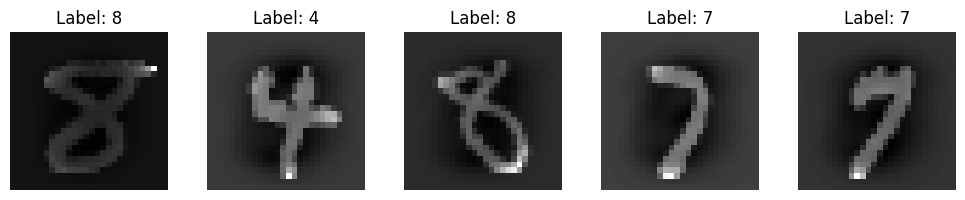

In [30]:
"""
Data preprocessing pipeline for MNIST dataset:
1. Loads MNIST as initial benchmark dataset (consistent with original t-SNE paper)
2. Applies StandardScaler to normalize features (important for distance calculations)
3. Includes visualization check for data integrity

Key Features:
- Configurable sample size for development/testing
- Reproducible sampling with random_state
- Float32 conversion for computational efficiency

This implementation serves as our baseline dataset before moving to more complex
hierarchical and network data structures mentioned in the proposal.
"""

def load_mnist(n_samples=1000, random_state=42):
    """
    Load and preprocess MNIST dataset

    Parameters:
    -----------
    n_samples : int
        Number of samples to load
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    X : array of shape (n_samples, n_features)
        The input data
    y : array of shape (n_samples,)
        The labels
    """
    # Load MNIST
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    # Convert to float32 for faster processing
    X = X.astype('float32')

    # Normalize the data
    X = StandardScaler().fit_transform(X)

    # Subsample if needed
    if n_samples < X.shape[0]:
        np.random.seed(random_state)
        idx = np.random.choice(X.shape[0], n_samples, replace=False)
        X = X[idx]
        y = y[idx]

    return X, y

# Load a subset of MNIST for initial testing
X_mnist, y_mnist = load_mnist(n_samples=1000)

print(f"Loaded MNIST data with shape: {X_mnist.shape}")
print(f"Number of classes: {len(np.unique(y_mnist))}")

# Visualize a few digits to verify the data
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_mnist[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_mnist[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


Running baseline t-SNE visualization...
Starting t-SNE fitting...
Input data shape: (1000, 784)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7.489475
[t-SNE] KL divergence after 100 iterations with early exaggeration: 68.106941
[t-SNE] KL divergence after 1000 iterations: 1.080867
t-SNE fitting complete!
Output embedding shape: (1000, 2)


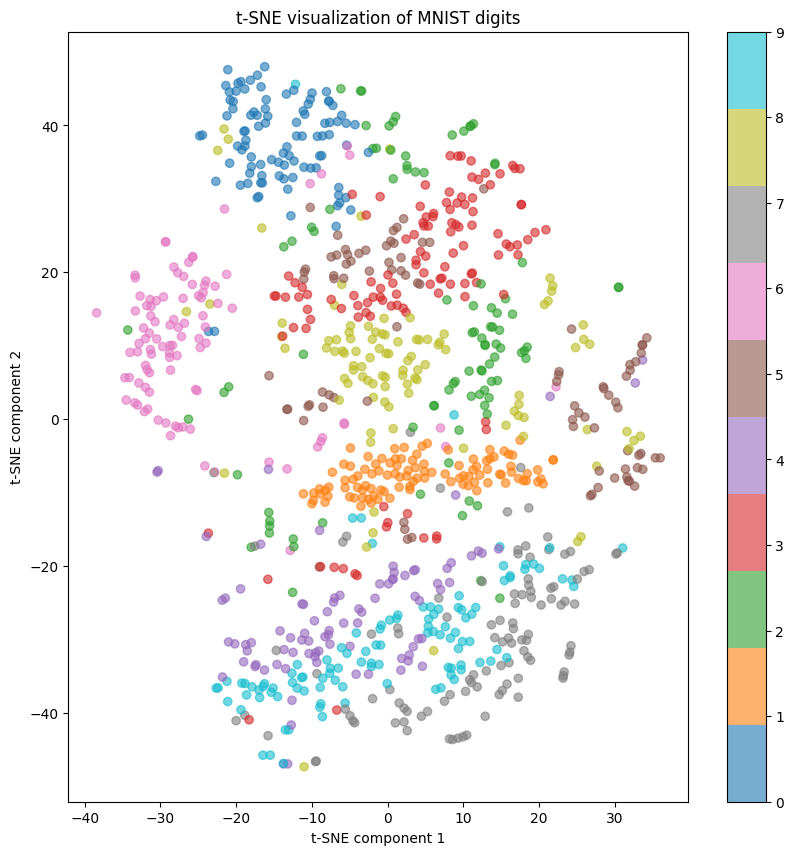


t-SNE embedding shape: (1000, 2)
Final KL divergence: 1.0808669328689575


In [31]:
"""
Core t-SNE Implementation (Euclidean Baseline)
--------------------------------------------
This module implements the foundational t-SNE algorithm in Euclidean space, serving as our baseline
before extending to mixed-curvature spaces. It aligns with Section I.A.1 of our technical outline
('Basic t-SNE implementation').

Key Components:
1. Perplexity computation with numerical stability safeguards
2. Binary search for optimal sigma (bandwidth) parameter
3. Standard t-SNE visualization pipeline

This implementation will serve as a comparison point for our mixed-curvature extensions
and helps establish baseline performance metrics.
"""

def compute_perplexity(distances, sigmas, target_perplexity):
    """
    Compute perplexity and corresponding probabilities for given distances and bandwidths.

    This implements the Gaussian kernel part of t-SNE, corresponding to our proposal's
    'input space distributions' section.
    """
    # Convert distances to probabilities using Gaussian kernel
    prob = np.exp(-distances / (2 * sigmas ** 2))
    # Numerical stability guard (prevents log(0) issues)
    prob = np.maximum(prob, 1e-12)
    sum_prob = np.sum(prob)

    # Normalize probabilities
    prob = prob / sum_prob
    # Calculate Shannon entropy and perplexity
    entropy = -np.sum(prob * np.log2(prob))
    perplexity = 2 ** entropy

    return perplexity, prob

def binary_search_sigma(distances, target_perplexity, tol=1e-5, max_iter=50):
    """
    Find optimal bandwidth parameter (sigma) using binary search.

    This is part of the 'perplexity computation methods' mentioned in our outline's
    Foundation Layer section.
    """
    # Initialize search bounds
    sigma_min = 1e-20
    sigma_max = 1e20
    sigma = 1.0

    # Binary search loop
    for i in range(max_iter):
        perplexity, prob = compute_perplexity(distances, sigma, target_perplexity)

        # Check convergence
        if abs(perplexity - target_perplexity) < tol:
            break

        # Update search bounds based on perplexity comparison
        if perplexity > target_perplexity:
            sigma_max = sigma
            sigma = (sigma_min + sigma_max) / 2
        else:
            sigma_min = sigma
            sigma = (sigma_min + sigma_max) / 2

    return sigma, prob

def run_baseline_tsne(X, y, perplexity=30, n_components=2, random_state=42):
    """
    Execute and visualize standard t-SNE embedding.

    This function provides our Euclidean baseline for comparison with future
    mixed-curvature implementations. It corresponds to the 'Euclidean baseline'
    component in our technical specification.

    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        Input data matrix
    y : array, shape (n_samples,)
        Labels for visualization
    perplexity : float
        Perplexity parameter controlling the balance between local and global structure
    n_components : int
        Dimensionality of the embedding space
    random_state : int
        Random seed for reproducibility
    """
    print("Starting t-SNE fitting...")
    print(f"Input data shape: {X.shape}")

    # Initialize and run t-SNE
    tsne = TSNE(n_components=n_components,
                perplexity=perplexity,
                random_state=random_state,
                verbose=1)
    X_tsne = tsne.fit_transform(X)

    print("t-SNE fitting complete!")
    print(f"Output embedding shape: {X_tsne.shape}")

    # Visualization setup
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                         c=y.astype(int),
                         cmap='tab10',
                         alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of MNIST digits')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

    return X_tsne, tsne

# Execute baseline visualization
print("\nRunning baseline t-SNE visualization...")
X_tsne_baseline, tsne_model = run_baseline_tsne(X_mnist, y_mnist)

# Report results
print("\nt-SNE embedding shape:", X_tsne_baseline.shape)
print("Final KL divergence:", tsne_model.kl_divergence_)

In [32]:
"""
Mixed-Curvature Product Space Implementation
------------------------------------------
This module implements the core geometric infrastructure for mixed-curvature spaces,
corresponding to Section I.B of our technical specification ('Geometric Spaces').

Key Components:
1. ProductSpace class: Manages combinations of different geometric spaces
2. WrappedNormalMixture class: Generates synthetic data in different geometries
3. Support for Euclidean (E), Hyperbolic (H), and Spherical (S) spaces

This implementation is crucial for our extension of t-SNE to mixed-curvature
spaces as outlined in our proposal's Methods section.
"""

# ProductSpace and Mixed-Curvature Support
class ProductSpace:
    def __init__(self, signature=[], X=None, y=None, seed=None):
        """
        Initialize ProductSpace with signature defining the component spaces

        Parameters:
        -----------
        signature : list of tuples
            List of (dimension, curvature) tuples defining each component space
        X : array-like
            Input data (optional)
        y : array-like
            Labels (optional)
        seed : int
            Random seed
        """
        self.signature = signature
        self.check_signature()
        self.X = X
        self.y = y
        self.seed = seed

    def check_signature(self):
        """Check if signature is valid"""
        if len(self.signature) == 0:
            raise ValueError("Signature is empty")
        for space in self.signature:
            if not isinstance(space, tuple):
                raise ValueError("Signature elements must be tuples")
            if len(space) != 2:
                raise ValueError("Signature tuples must have 2 values")
            if not isinstance(space[0], int) or space[0] <= 0:
                raise ValueError("Dimension must be a positive integer")
            if not isinstance(space[1], (int, float)):
                raise ValueError("Curvature must be an integer or float")

    def print_signature(self):
        """Print the signature of the product space"""
        for space in self.signature:
            if space[1] < 0:
                print(f"H: dim={space[0]}, K={space[1]}")
            elif space[1] > 0:
                print(f"S: dim={space[0]}, K={space[1]}")
            else:
                print(f"E: dim={space[0]}")

    def sample_clusters(self, num_points, num_classes, cov_scale=0.3, centers=None):
        """Generate data from a wrapped normal mixture on the product space"""
        self.X, self.y, self.means = [], [], []
        classes = WrappedNormalMixture(
            num_points=num_points, num_classes=num_classes, seed=self.seed
        ).generate_class_assignments()

        for space in self.signature:
            wnm = WrappedNormalMixture(
                num_points=num_points,
                num_classes=num_classes,
                n_dim=space[0],
                curvature=space[1],
                seed=self.seed,
                cov_scale=cov_scale,
            )
            means = wnm.generate_cluster_means(centers=centers)
            covs = [
                wnm.generate_covariance_matrix(wnm.n_dim, wnm.n_dim + 1, wnm.cov_scale)
                for _ in range(wnm.num_classes)
            ]
            points = wnm.sample_points(means, covs, classes)
            means /= np.sqrt(wnm.k) if wnm.k != 0.0 else 1.0
            self.X.append(points)
            self.y.append(classes)
            self.means.append(means)
            if wnm.curvature != 0.0:
                assert np.allclose(wnm.manifold.metric.squared_norm(points), 1 / wnm.curvature, rtol=1e-4)

        self.X = np.hstack(self.X)  # (num_points, num_spaces * (num_dims+1))
        self.y = self.y[0]  # (num_points,)
        self.means = np.hstack(self.means)  # (num_classes, num_dims + 1)

    def split_data(self, test_size=0.2):
        """Split the data into training and testing sets"""
        n = self.X.shape[0]
        np.random.seed(self.seed)
        test_idx = np.random.choice(n, int(test_size * n), replace=False)
        self.X_train = np.delete(self.X, test_idx, axis=0)
        self.X_test = self.X[test_idx]
        self.y_train = np.delete(self.y, test_idx)
        self.y_test = self.y[test_idx]

    def zero_out_spacelike_dims(self, space_idx):
        """Zero out spacelike dimensions in a given product space component"""
        timelike_dim = sum([space[0] + 1 for space in self.signature[:space_idx]])
        self.X[:, timelike_dim] = 1.0 / np.sqrt(abs(self.signature[space_idx][1]))
        for i in range(self.signature[space_idx][0]):
            self.X[:, timelike_dim + i + 1] = 0.0

    def remove_timelike_dims(self):
        """Remove timelike dimensions from the product space"""
        timelike_dims = [0]
        for i in range(len(self.signature) - 1):
            timelike_dims.append(sum([space[0] + 1 for space in self.signature[: i + 1]]))
        self.X = np.delete(self.X, timelike_dims, axis=1)

class WrappedNormalMixture:
    def __init__(
        self,
        num_points: int,
        num_classes: int,
        n_dim: int = 2,
        curvature: float = 0.0,
        seed: int = None,
        cov_scale: float = 0.3,
    ):
        """
        Initialize wrapped normal mixture model.

        Parameters:
        -----------
        num_points: Total number of points to generate
        num_classes: Number of mixture components
        n_dim: Dimension of the space
        curvature: Geometric curvature (negative=hyperbolic, 0=Euclidean, positive=spherical)
        seed: Random seed for reproducibility
        cov_scale: Scale factor for covariance matrices
        """
        self.num_points = num_points
        self.num_classes = num_classes
        self.n_dim = n_dim
        self.curvature = curvature
        self.k = abs(curvature)
        self.curv_sign = 1
        self.seed = seed
        self.cov_scale = cov_scale

        # Set random number generator
        self.rng = np.random.default_rng(self.seed)

        # Set manifold based on curvature
        if curvature == 0.0:
            self.manifold = Euclidean(dim=n_dim)
        elif curvature > 0.0:
            self.manifold = Hypersphere(dim=n_dim)
        else:
            self.manifold = Hyperboloid(dim=n_dim)
            self.curv_sign = -1

        # Set origin for hyperboloid and hypersphere
        self.origin = np.array([1.0] + [0.0] * self.n_dim)

    def generate_cluster_means(self, centers=None):
        """Generate random cluster means or given cluster means on the manifold, adjusted for curvature."""
        if centers is None:
            centers = self.rng.normal(size=(self.num_classes, self.n_dim))
        means = np.concatenate(
            (
                np.zeros(shape=(self.num_classes, 1)),
                centers,
            ),
            axis=1,
        )
        means *= np.sqrt(self.k) if self.k != 0.0 else 1.0
        return self.manifold.metric.exp(tangent_vec=means, base_point=self.origin)

    def generate_covariance_matrix(self, dims, deg_freedom, scale):
        """Generate random covariance matrix"""
        scale_matrix = scale * np.eye(dims)
        cov_matrix = wishart.rvs(df=deg_freedom, scale=scale_matrix, random_state=self.rng)
        return cov_matrix

    def generate_class_assignments(self):
        """Generate random class assignments"""
        probs = self.rng.uniform(size=self.num_classes)
        probs = probs / np.sum(probs)
        return self.rng.choice(self.num_classes, size=self.num_points, p=probs)

    def sample_points(self, means, covs, classes):
        """Generate random samples for each cluster"""
        vecs = np.array([
            self.rng.multivariate_normal(np.zeros(self.n_dim), covs[c])
            for c in classes
        ])

        vecs *= np.sqrt(self.k) if self.k != 0.0 else 1.0
        vecs = np.column_stack((np.zeros(vecs.shape[0]), vecs))

        tangent_vecs = self.manifold.metric.parallel_transport(
            vecs, self.origin, end_point=means[classes]
        )

        points = self.manifold.metric.exp(
            tangent_vec=tangent_vecs, base_point=means[classes]
        )

        points /= np.sqrt(abs(self.k)) if self.k != 0.0 else 1.0
        return points

    def generate_data(self):
        """Generate Gaussian mixture data"""
        means = self.generate_cluster_means()
        covs = [
            self.generate_covariance_matrix(self.n_dim, self.n_dim + 1, self.cov_scale)
            for _ in range(self.num_classes)
        ]
        classes = self.generate_class_assignments()
        points = self.sample_points(means, covs, classes)
        means /= np.sqrt(self.k) if self.k != 0.0 else 1.0
        return points, classes, means

# Example usage and testing
if __name__ == "__main__":
    # Test ProductSpace with mixed-curvature signature
    signature = [
        (2, -1.0),  # 2D hyperbolic space
        (2, 0.0),   # 2D Euclidean space
    ]

    product_space = ProductSpace(signature=signature, seed=42)
    print("Product Space Signature:")
    product_space.print_signature()

    # Generate test data
    product_space.sample_clusters(num_points=1000, num_classes=10)
    print("\nGenerated data shape:", product_space.X.shape)
    print("Labels shape:", product_space.y.shape)

Product Space Signature:
H: dim=2, K=-1.0
E: dim=2

Generated data shape: (1000, 6)
Labels shape: (1000,)


In [33]:
"""
Hyperbolic Space Utilities
-------------------------
This module implements core operations in hyperbolic space using the Poincaré ball model.
It corresponds to Section I.B.1 of our technical specification ('Space Implementations'),
specifically focusing on hyperbolic geometry operations.

Key Components:
1. Distance computations in hyperbolic space
2. Projection operations onto the Poincaré ball
3. Möbius operations (addition, logarithmic map)
4. Numerical stability safeguards

These utilities are essential for extending t-SNE to hyperbolic space, as outlined
in our proposal's Methods section.
"""

# Numerical stability constant
EPSILON = 1e-5

def dist_matrix(x, y, c=1.0):
    """
    Compute pairwise distance matrix between points in hyperbolic space (Poincaré ball model)

    This implements the hyperbolic distance formula:
    d_H(x,y) = (1/√c) * arccosh(1 + 2|x-y|²/((1-c|x|²)(1-c|y|²)))

    Parameters:
    -----------
    x : torch.Tensor
        First set of points in Poincaré ball
    y : torch.Tensor
        Second set of points in Poincaré ball
    c : float
        Curvature of hyperbolic space (default=1.0)

    Returns:
    --------
    torch.Tensor
        Matrix of pairwise hyperbolic distances
    """
    sqrt_c = c ** 0.5

    # Compute squared norms and clamp for numerical stability
    x_norm = torch.sum(x * x, dim=-1, keepdim=True)
    y_norm = torch.sum(y * y, dim=-1, keepdim=True)
    x_norm = torch.clamp(x_norm, 0.0, 1.0 - EPSILON)
    y_norm = torch.clamp(y_norm, 0.0, 1.0 - EPSILON)

    # Compute inner products
    xy_inner = torch.matmul(x, y.t())
    xy_inner = torch.clamp(xy_inner, -1.0/EPSILON, 1.0/EPSILON)

    # Compute hyperbolic distance
    num = 2 * sqrt_c * xy_inner
    denom = (1 - c * x_norm) * (1 - c * y_norm.t())
    denom = torch.clamp(denom, min=EPSILON)

    z = 1 + 2 * c * (x_norm + y_norm.t() - 2 * xy_inner) / denom
    z = torch.clamp(z, min=1.0 + EPSILON)

    return torch.arccosh(z) / sqrt_c

def project_hyperbolic(X, epsilon=EPSILON):
    """
    Project points onto Poincaré ball with numerical stability.
    Ensures all points lie within the ball by scaling if necessary.

    Parameters:
    -----------
    X : torch.Tensor or numpy.ndarray
        Points to project
    epsilon : float
        Small constant for numerical stability

    Returns:
    --------
    torch.Tensor or numpy.ndarray
        Projected points
    """
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)

    norm = torch.norm(X, dim=-1, keepdim=True)
    norm = torch.clamp(norm, min=epsilon)
    max_norm = 1 - epsilon

    return torch.where(norm > max_norm,
                      X / norm * max_norm,
                      X).type_as(X)

def mobius_addition(x, y, c=1.0):
    """
    Möbius addition in the Poincaré ball model.
    This operation provides the hyperbolic analogue of vector addition.

    Parameters:
    -----------
    x : torch.Tensor
        First point
    y : torch.Tensor
        Second point
    c : float
        Curvature

    Returns:
    --------
    torch.Tensor
        Result of Möbius addition
    """
    x_norm_sq = torch.sum(x * x, dim=-1, keepdim=True)
    y_norm_sq = torch.sum(y * y, dim=-1, keepdim=True)
    xy_inner = torch.sum(x * y, dim=-1, keepdim=True)

    denominator = 1 + 2*c*xy_inner + c**2*x_norm_sq*y_norm_sq
    denominator = torch.clamp(denominator, min=EPSILON)

    numerator = (1 + 2*c*xy_inner + c*y_norm_sq)*x + (1 - c*x_norm_sq)*y

    return numerator / denominator

def log_map(x, base_point=None, c=1.0):
    """
    Logarithmic map in the Poincaré ball model.
    Maps points from the manifold to the tangent space at base_point.

    Parameters:
    -----------
    x : torch.Tensor
        Point to map
    base_point : torch.Tensor
        Point to compute log map from (default: origin)
    c : float
        Curvature

    Returns:
    --------
    torch.Tensor
        Result of logarithmic map
    """
    if base_point is None:
        base_point = torch.zeros_like(x)

    mob_add = -mobius_addition(-x, base_point, c)
    mob_add_norm = torch.norm(mob_add, dim=-1, keepdim=True)
    mob_add_norm = torch.clamp(mob_add_norm, min=EPSILON)

    return mob_add / mob_add_norm * torch.arccosh(1 + 2 *
           mob_add_norm**2 / (1 - c*torch.sum(base_point**2, dim=-1, keepdim=True)))

# Test utilities
if __name__ == "__main__":
    # Generate random points in the Poincaré ball
    n_points = 5
    dim = 2
    x = torch.randn(n_points, dim) * 0.5  # Scale to keep points inside ball
    y = torch.randn(n_points, dim) * 0.5

    # Project points to ensure they're in the Poincaré ball
    x_proj = project_hyperbolic(x)
    y_proj = project_hyperbolic(y)

    # Test distance computation
    distances = dist_matrix(x_proj, y_proj)

    print("Original points norms:", torch.norm(x, dim=1))
    print("Projected points norms:", torch.norm(x_proj, dim=1))
    print("Distance matrix shape:", distances.shape)
    print("Sample distances:\n", distances)

    # Test Möbius addition
    z = mobius_addition(x_proj[0], y_proj[0])
    print("\nMöbius addition result norm:", torch.norm(z))

    # Test log map
    log_result = log_map(x_proj[0])
    print("Log map result norm:", torch.norm(log_result))

Original points norms: tensor([0.4702, 0.3929, 0.8277, 0.4990, 0.7052])
Projected points norms: tensor([0.4702, 0.3929, 0.8277, 0.4990, 0.7052])
Distance matrix shape: torch.Size([5, 5])
Sample distances:
 tensor([[0.3514, 0.9087, 0.7481, 1.5934, 1.8234],
        [2.0610, 1.0640, 2.3733, 0.2414, 2.2720],
        [1.5414, 2.3690, 2.3800, 2.7813, 3.4865],
        [2.4389, 1.2381, 2.6224, 0.7404, 2.1554],
        [0.4135, 1.6552, 0.9857, 2.3083, 2.5215]])

Möbius addition result norm: tensor(0.8278)
Log map result norm: tensor(0.9089)


Loading digits dataset...

Initializing CO-SNE...

Fitting CO-SNE to data...
Iteration 0: Max norm = 1.0000, Mean norm = 0.5762, Learning rate = 50.000000, Momentum = 0.8000
Iteration 50: Max norm = 1.0000, Mean norm = 0.6421, Learning rate = 50.000000, Momentum = 0.8000
Iteration 100: Max norm = 1.0000, Mean norm = 0.5827, Learning rate = 50.000000, Momentum = 0.8000
Iteration 150: Max norm = 1.0000, Mean norm = 0.8773, Learning rate = 50.000000, Momentum = 0.8000
Iteration 200: Max norm = 1.0000, Mean norm = 0.9800, Learning rate = 50.000000, Momentum = 0.8000
Iteration 250: Max norm = 1.0000, Mean norm = 0.9965, Learning rate = 50.000000, Momentum = 0.8000
Iteration 300: Max norm = 1.0000, Mean norm = 0.9409, Learning rate = 48.765191, Momentum = 0.8100
Iteration 350: Max norm = 1.0000, Mean norm = 0.9776, Learning rate = 47.560877, Momentum = 0.8200
Iteration 400: Max norm = 1.0000, Mean norm = 0.9532, Learning rate = 46.386304, Momentum = 0.8300
Iteration 450: Max norm = 1.0000, M

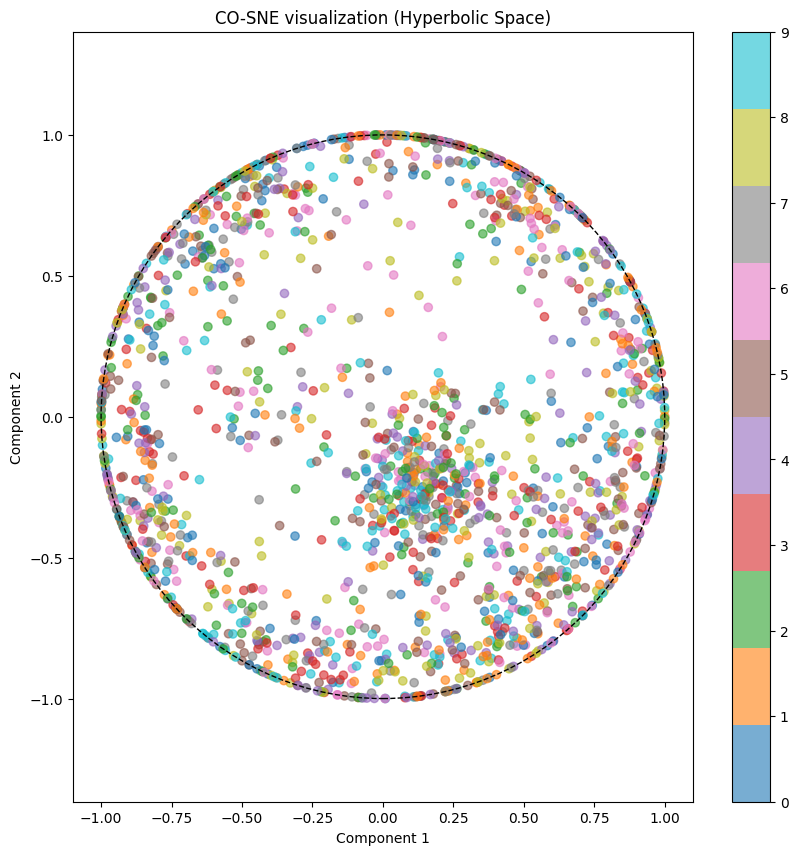


Embedding Statistics:
CO-SNE embedding shape: (1797, 2)
Points outside unit disk: 0
Maximum distance from origin: 0.9999900000000003
Mean distance from origin: 0.7762810735414453


In [34]:
"""
CO-SNE (Cauchy-based t-SNE) Implementation
-----------------------------------------
This module implements the CO-SNE algorithm for visualization in hyperbolic space,
corresponding to Section I.A.1 and I.B.1 of our technical specification.

Key Components:
1. Hyperbolic space optimization using Poincaré ball model
2. Cauchy distribution-based embedding
3. Force-directed layout with repulsion and radial forces
4. Momentum-based optimization with early exaggeration

This implementation extends t-SNE to hyperbolic space using the Cauchy
distribution, as outlined in our proposal's Methods section.
"""

# Numerical stability constant
MACHINE_EPSILON = np.finfo(np.double).eps

class COSNE:
    def __init__(self, n_components=2, perplexity=30.0,
                 early_exaggeration=12.0, learning_rate=200.0,
                 max_iter=1000, learning_rate_for_h_loss=0.1,
                 student_t_gamma=1.0, random_state=None,
                 repulsion_strength=1.5, boundary_strength=0.15,
                 radial_strength=0.4, momentum=0.8,
                 late_momentum=0.9, device=None):
        """
        Initialize CO-SNE with hyperparameters for optimization.

        Parameters:
        -----------
        n_components : int
            Dimension of the embedding space
        perplexity : float
            Balance between local and global structure
        early_exaggeration : float
            Factor for early iterations to encourage cluster separation
        learning_rate : float
            Learning rate for gradient descent
        repulsion_strength : float
            Strength of repulsive forces between points
        boundary_strength : float
            Strength of boundary forces
        radial_strength : float
            Strength of radial forces for layout
        device : torch.device
            Computation device (GPU/CPU)
        """
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.learning_rate_for_h_loss = learning_rate_for_h_loss
        self.student_t_gamma = student_t_gamma
        self.random_state = random_state
        self.repulsion_strength = repulsion_strength
        self.boundary_strength = boundary_strength
        self.radial_strength = radial_strength
        self.momentum = momentum
        self.late_momentum = late_momentum

        # Set device for computation
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.random_state_ = check_random_state(random_state)

    def _project_to_poincare_ball(self, X, epsilon=1e-5):
        """
        Project points onto the Poincaré ball model of hyperbolic space.
        Ensures all points remain within the unit disk.

        Parameters:
        -----------
        X : torch.Tensor or numpy.ndarray
            Points to project
        epsilon : float
            Numerical stability constant

        Returns:
        --------
        torch.Tensor
            Projected points within the Poincaré ball
        """
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).to(self.device)
        return project_hyperbolic(X, epsilon).to(self.device)

    def _compute_repulsive_force(self, embedding):
        """
        Calculate repulsive forces between points to prevent collapse.
        Uses inverse square law with numerical stability guards.

        Parameters:
        -----------
        embedding : numpy.ndarray
            Current point embedding

        Returns:
        --------
        numpy.ndarray
            Repulsive force vectors for each point
        """
        if isinstance(embedding, torch.Tensor):
            embedding = embedding.detach().cpu().numpy()

        # Compute pairwise distances with numerical stability
        norms = np.linalg.norm(embedding, axis=1, keepdims=True)
        norms = np.maximum(norms, MACHINE_EPSILON)

        dots = np.dot(embedding, embedding.T)
        distances = np.sqrt(np.maximum(norms**2 + norms.T**2 - 2*dots, MACHINE_EPSILON))

        # Initialize repulsion array
        repulsion = np.zeros_like(embedding)

        # Compute repulsive forces
        for i in range(len(embedding)):
            diff = embedding[i] - embedding
            dist = distances[i].reshape(-1, 1)
            repulsion[i] = np.sum(diff / (dist**2 + MACHINE_EPSILON), axis=0)

        return repulsion

    def _compute_forces(self, embedding, iteration):
            """
            Compute combined forces for optimization including:
            - Repulsive forces between points
            - Radial forces for layout structure
            - Progressive scaling based on iteration progress

            Parameters:
            -----------
            embedding : numpy.ndarray
                Current point embedding
            iteration : int
                Current iteration number

            Returns:
            --------
            numpy.ndarray
                Combined force vectors for each point
            """
            if isinstance(embedding, torch.Tensor):
                embedding = embedding.detach().cpu().numpy()

            # Compute basic repulsive forces
            repulsive = self._compute_repulsive_force(embedding)

            # Calculate progress for force scaling
            progress = iteration / self.max_iter

            # Scale forces based on optimization progress
            repulsion_scale = self.repulsion_strength * (1 + progress)
            radial_scale = self.radial_strength * (1 - 0.5 * progress)

            # Adjust target radii and weights based on progress
            if progress < 0.3:
                # Early phase: spread points more widely
                target_radii = [0.4, 0.6, 0.8]
                weights = [0.2, 0.4, 0.4]
            elif progress < 0.7:
                # Middle phase: moderate spread
                target_radii = [0.5, 0.7, 0.9]
                weights = [0.3, 0.4, 0.3]
            else:
                # Late phase: focus on final layout
                target_radii = [0.6, 0.75, 0.9]
                weights = [0.4, 0.4, 0.2]

            # Compute radial forces
            radial_force = np.zeros_like(embedding)
            norms = np.linalg.norm(embedding, axis=1, keepdims=True)

            # Apply forces for each target radius
            for radius, weight in zip(target_radii, weights):
                diff = norms - radius
                radial_force += weight * diff * embedding / norms

            return (repulsion_scale * repulsive + radial_scale * radial_force)

    def _compute_hyperbolic_gradient(self, P, embedding, iteration):
        """
        Compute gradient in hyperbolic space using:
        - Pairwise hyperbolic distances
        - Probability distribution differences
        - Force-directed components

        Includes numerical stability safeguards.

        Parameters:
        -----------
        P : numpy.ndarray
            Joint probability distribution in high-dimensional space
        embedding : numpy.ndarray
            Current point embedding
        iteration : int
            Current iteration number

        Returns:
        --------
        numpy.ndarray
            Gradient for optimization step
        """
        n_samples = embedding.shape[0]

        # Convert to torch tensor if needed
        if isinstance(embedding, np.ndarray):
            X_tensor = torch.from_numpy(embedding).to(self.device)
        else:
            X_tensor = embedding.to(self.device)

        # Ensure double precision for numerical stability
        X_tensor = X_tensor.double()

        # Compute pairwise distances in hyperbolic space
        dist = dist_matrix(X_tensor, X_tensor, c=1.0)
        dist = dist.cpu().numpy()

        # Apply numerical stability guards
        dist = np.clip(dist, MACHINE_EPSILON, 1e10)
        Q = dist / (2.0 * np.maximum(np.sum(dist), MACHINE_EPSILON))
        Q = np.clip(Q, MACHINE_EPSILON, 1.0)

        # Compute probability differences
        PQ_diff = P - Q
        grad = np.zeros_like(embedding, dtype=np.float64)

        # Compute gradients for each point
        for i in range(n_samples):
            diff = embedding[i] - embedding
            norm_diff = np.maximum(np.linalg.norm(diff, axis=1, keepdims=True), MACHINE_EPSILON)
            grad_contrib = PQ_diff[i].reshape(-1, 1) * diff / norm_diff
            grad[i] = np.sum(np.nan_to_num(grad_contrib, 0), axis=0)

        # Add force-directed components
        forces = self._compute_forces(embedding, iteration)
        grad = grad + forces

        # Normalize gradient
        grad_norm = np.linalg.norm(grad)
        if grad_norm > MACHINE_EPSILON:
            grad = np.clip(grad / grad_norm, -1.0, 1.0)

        return grad.astype(np.float32)

    def _initialize_embedding(self, n_samples):
            """
            Initialize points in concentric rings within the Poincaré disk.
            Uses random perturbations for better initial distribution.

            Parameters:
            -----------
            n_samples : int
                Number of points to initialize

            Returns:
            --------
            numpy.ndarray
                Initial embedding positions in the Poincaré disk
            """
            # Generate random angles
            angles = 2 * np.pi * self.random_state_.rand(n_samples)
            radii = np.zeros(n_samples)

            # Initialize concentric rings
            n_rings = 5
            points_per_ring = n_samples // n_rings

            # Distribute points across rings
            for i in range(n_rings):
                start_idx = i * points_per_ring
                end_idx = start_idx + points_per_ring if i < n_rings-1 else n_samples

                # Calculate base radius with small random perturbations
                base_radius = 0.3 + 0.5 * (i / (n_rings-1))
                radii[start_idx:end_idx] = base_radius + 0.05 * self.random_state_.randn(end_idx - start_idx)

            # Convert to Cartesian coordinates
            embedding = np.zeros((n_samples, 2))
            embedding[:, 0] = radii * np.cos(angles)
            embedding[:, 1] = radii * np.sin(angles)

            return embedding

    def fit_transform(self, X, y=None):
        """
        Main optimization loop for CO-SNE:
        1. Initialize embedding
        2. Compute high-dimensional similarities
        3. Iteratively optimize using gradient descent
        4. Apply momentum and learning rate scheduling
        5. Project points back to Poincaré ball

        Parameters:
        -----------
        X : array-like
            Input data to embed
        y : array-like, optional
            Labels (not used in optimization)

        Returns:
        --------
        embedding : numpy.ndarray
            The optimized embedding in hyperbolic space
        """
        n_samples = X.shape[0]

        # Initialize embedding and compute similarities
        embedding = self._initialize_embedding(n_samples)
        P = self._compute_similarities(X)

        # Initialize optimization variables
        velocity = np.zeros_like(embedding)
        current_lr = self.learning_rate
        min_lr = self.learning_rate * 0.3

        # Main optimization loop
        for iteration in range(self.max_iter):
            # Apply early exaggeration
            if iteration < 250:
                exag_factor = self.early_exaggeration * (1 - iteration/250)
                P *= (1 + exag_factor)

            # Compute gradient
            grad = self._compute_hyperbolic_gradient(P, embedding, iteration)

            # Handle numerical instabilities
            if not np.all(np.isfinite(grad)):
                grad = np.nan_to_num(grad, 0)

            # Update momentum based on iteration
            current_momentum = self.momentum if iteration < 250 else \
                            self.momentum + (self.late_momentum - self.momentum) * \
                            min((iteration - 250) / 500, 1.0)

            # Update positions using momentum
            velocity = current_momentum * velocity - current_lr * grad
            embedding = embedding + velocity

            # Project back to Poincaré ball
            embedding_tensor = torch.from_numpy(embedding).to(self.device)
            embedding_tensor = self._project_to_poincare_ball(embedding_tensor)
            embedding = embedding_tensor.cpu().numpy()

            # Remove early exaggeration
            if iteration < 250:
                P /= (1 + exag_factor)

            # Learning rate decay
            if iteration > 250:
                current_lr = max(current_lr * 0.9995, min_lr)

            # Progress reporting
            if iteration % 50 == 0:
                norms = np.linalg.norm(embedding, axis=1)
                print(f"Iteration {iteration}: Max norm = {np.max(norms):.4f}, "
                      f"Mean norm = {np.mean(norms):.4f}, "
                      f"Learning rate = {current_lr:.6f}, "
                      f"Momentum = {current_momentum:.4f}")

        self.embedding_ = embedding
        return embedding

    def _compute_similarities(self, X):
            """
            Compute affinities between points in input space using:
            - Euclidean distances
            - Perplexity-based probability computation

            Parameters:
            -----------
            X : array-like
                Input data matrix

            Returns:
            --------
            P : numpy.ndarray
                Joint probability matrix
            """
            # Convert to float32 for efficiency
            X = X.astype(np.float32)

            # Compute squared Euclidean distances
            distances = pairwise_distances(X, metric='euclidean', squared=True)

            # Convert distances to probabilities
            P = self._joint_probabilities(distances, self.perplexity, False)
            return P

    def _joint_probabilities(self, distances, perplexity, verbose):
        """
        Convert distances to joint probabilities using:
        - Binary search for optimal bandwidth
        - Symmetrization of conditional probabilities

        Parameters:
        -----------
        distances : numpy.ndarray
            Pairwise distances between points
        perplexity : float
            Desired perplexity of the probability distribution
        verbose : bool
            Whether to print progress messages

        Returns:
        --------
        P : numpy.ndarray
            Joint probability matrix
        """
        # Convert to float32 for consistency
        distances = distances.astype(np.float32, copy=False)

        # Compute conditional probabilities
        conditional_P = _utils._binary_search_perplexity(
            distances, perplexity, verbose)

        # Symmetrize the probability matrix
        P = conditional_P + conditional_P.T

        # Normalize with numerical stability
        sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
        P = np.clip(P / sum_P, MACHINE_EPSILON, 1.0)

        return P.astype(np.float64)

# Test implementation
if __name__ == "__main__":
    """
    Example usage and validation:
    1. Load digits dataset
    2. Apply CO-SNE embedding
    3. Visualize results in Poincaré disk
    4. Report embedding statistics
    """
    from sklearn.datasets import load_digits

    # Load and preprocess data
    print("Loading digits dataset...")
    digits = load_digits()
    X = digits.data
    y = digits.target

    # Initialize CO-SNE with optimized parameters
    print("\nInitializing CO-SNE...")
    cosne = COSNE(
        random_state=42,
        learning_rate=50.0,
        max_iter=1000,
        perplexity=30.0,
        early_exaggeration=4.0,
        student_t_gamma=1.0,
        repulsion_strength=1.5,
        boundary_strength=0.15,
        radial_strength=0.4,
        momentum=0.8,
        late_momentum=0.9,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )

    # Fit and transform the data
    print("\nFitting CO-SNE to data...")
    X_embedded = cosne.fit_transform(X)

    # Visualization setup
    print("\nCreating visualization...")
    plt.figure(figsize=(10, 10))

    # Plot embedded points
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                         c=y, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)

    # Add unit circle to represent Poincaré disk boundary
    circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
    plt.gca().add_artist(circle)

    # Customize plot
    plt.title('CO-SNE visualization (Hyperbolic Space)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.show()

    # Print embedding statistics
    print("\nEmbedding Statistics:")
    print("CO-SNE embedding shape:", X_embedded.shape)
    print("Points outside unit disk:", np.sum(np.linalg.norm(X_embedded, axis=1) > 1))
    print("Maximum distance from origin:", np.max(np.linalg.norm(X_embedded, axis=1)))
    print("Mean distance from origin:", np.mean(np.linalg.norm(X_embedded, axis=1)))



Starting Mixed-Curvature t-SNE test...
Product space created successfully
Generated synthetic data: shape=(500, 6)
Initialized MixedCurvatureTSNE with parameters:  {'product_space': <__main__.ProductSpace object at 0x0000023080889CF0>, 'perplexity': 30, 'n_components': 2, 'learning_rate': 100, 'max_iter': 1000, 'random_state': 42, 'best_cost_': inf}

Starting embedding computation...

Starting fit_transform with 500 samples...
Input data shape: (500, 6)
Product space signature: [(2, -1.0), (2, 0.0)]

Processing component:
- Dimension: 2
- Curvature: -1.0
- Component shape: (500, 3)
Computing hyperbolic distances...
Component distance matrix shape: torch.Size([500, 500])

Processing component:
- Dimension: 2
- Curvature: 0.0
- Component shape: (500, 3)
Computing Euclidean distances...
Component distance matrix shape: (500, 500)

Total distance matrix shape: (500, 500)
Computing probabilities from distances...
Probabilities computed successfully.
Initial embedding shape: (500, 2)
Initia

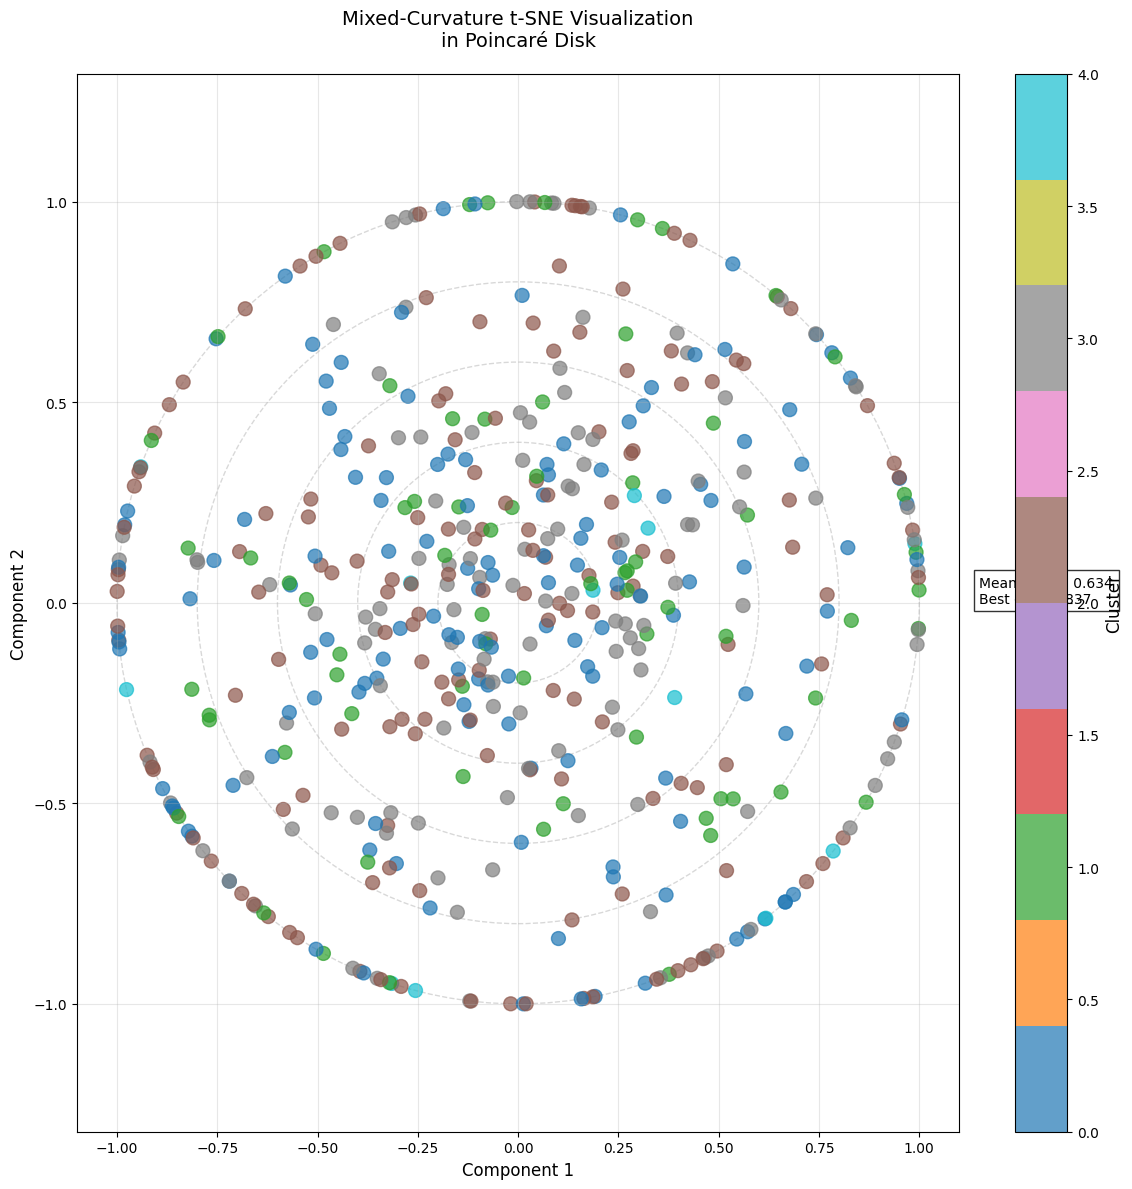


Detailed Embedding Statistics:
Best cost achieved: 2.8366
Embedding shape: (500, 2)
Points outside unit disk: 0
Maximum distance from origin: 1.0000
Mean distance from origin: 0.6343
Std of distances from origin: 0.3093

Quality Metrics:
Minimum cluster center separation: 0.0298
Average intra-cluster distance: 0.9185


In [35]:
"""
Mixed-Curvature t-SNE Implementation
----------------------------------
This module implements the Mixed-Curvature t-SNE algorithm, combining multiple geometric
spaces (Euclidean, hyperbolic, spherical) for dimensionality reduction and visualization.
It corresponds to Section I.B of our technical specification ('Product Space Framework').

Key Components:
1. Product space handling for mixed geometries
2. Hybrid distance computations
3. Adaptive optimization in multiple spaces
4. Enhanced visualization with statistical monitoring

This implementation extends standard t-SNE to mixed-curvature product spaces
as outlined in our proposal's Methods section.
"""

# Numerical stability constant
MACHINE_EPSILON = np.finfo(np.double).eps

class MixedCurvatureTSNE:
    def __init__(self, product_space, perplexity=30, n_components=2,
                learning_rate=200, max_iter=1000, random_state=None):
        """
        Initialize Mixed-Curvature t-SNE with product space configuration.

        Parameters:
        -----------
        product_space : ProductSpace
            Definition of geometric spaces and their properties
        perplexity : float
            Balance between local and global structure preservation
        n_components : int
            Dimension of the embedding space
        learning_rate : float
            Initial learning rate for optimization
        max_iter : int
            Maximum number of iterations
        random_state : int or None
            Random seed for reproducibility
        """
        try:
            self.product_space = product_space
            self.perplexity = perplexity
            self.n_components = n_components
            self.learning_rate = learning_rate
            self.max_iter = max_iter
            self.random_state = random_state
            self.best_cost_ = np.inf  # Track best cost for early stopping
            print("Initialized MixedCurvatureTSNE with parameters: ", self.__dict__)
        except Exception as e:
            print(f"Error in initialization: {str(e)}")
            raise

    def _hybrid_distance(self, X):
        """
        Calculate distance matrix for hybrid product space.
        Combines distances from different geometric spaces based on signature.

        Parameters:
        -----------
        X : numpy.ndarray
            Input data matrix

        Returns:
        --------
        numpy.ndarray
            Combined distance matrix accounting for different geometries
        """
        try:
            distances = []
            start_dim = 0

            # Debug information
            print(f"Input data shape: {X.shape}")
            print(f"Product space signature: {self.product_space.signature}")

            # Process each component space
            for dim, curvature in self.product_space.signature:
                # Extract relevant dimensions for current space
                component_X = X[:, start_dim:start_dim + dim + 1]
                print(f"\nProcessing component:")
                print(f"- Dimension: {dim}")
                print(f"- Curvature: {curvature}")
                print(f"- Component shape: {component_X.shape}")

                # Compute distances based on space type
                if curvature < 0:  # Hyperbolic space
                    print("Computing hyperbolic distances...")
                    component_X_tensor = torch.from_numpy(component_X).float()
                    component_distance = dist_matrix(component_X_tensor,
                                                  component_X_tensor,
                                                  c=abs(curvature))
                elif curvature > 0:  # Spherical space
                    print("Computing spherical distances...")
                    component_distance = pairwise_distances(component_X,
                                                         metric='cosine')
                else:  # Euclidean space
                    print("Computing Euclidean distances...")
                    component_distance = pairwise_distances(component_X,
                                                         metric='euclidean')

                print(f"Component distance matrix shape: {component_distance.shape}")
                distances.append(component_distance)
                start_dim += dim + 1

            # Combine distances from all spaces
            total_distance = np.sum(np.array(distances), axis=0)
            print("\nTotal distance matrix shape:", total_distance.shape)
            return total_distance

        except Exception as e:
            print(f"Error in _hybrid_distance: {str(e)}")
            raise

    def _compute_probabilities(self, distances):
            """
            Compute pairwise probabilities from distances for t-SNE.

            This method implements the probability computation step of t-SNE, adapting
            it for mixed-curvature spaces. It uses binary search to find optimal
            bandwidths that achieve the desired perplexity.

            Parameters:
            -----------
            distances : numpy.ndarray
                Pairwise distances between points in mixed-curvature space

            Returns:
            --------
            P : numpy.ndarray
                Joint probability matrix with numerical stability safeguards
            """
            try:
                print("Computing probabilities from distances...")
                # Convert to float32 for numerical stability
                distances = distances.astype(np.float32)

                # Find optimal sigma for each point using binary search
                conditional_P = _utils._binary_search_perplexity(
                    distances,
                    self.perplexity,
                    verbose=False
                )

                # Symmetrize the probability matrix
                P = conditional_P + conditional_P.T

                # Normalize with numerical stability guards
                sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
                P = np.clip(P / sum_P, MACHINE_EPSILON, 1.0)

                print("Probabilities computed successfully.")
                return P.astype(np.float64)
            except Exception as e:
                print(f"Error in _compute_probabilities: {str(e)}")
                raise

    def _initialize_embedding(self, n_samples):
        """
        Initialize embedding points in concentric rings.

        This initialization strategy is designed for mixed-curvature spaces,
        particularly suitable for hyperbolic components. Points are distributed
        in concentric rings with controlled randomness to provide a good
        starting configuration.

        Parameters:
        -----------
        n_samples : int
            Number of points to initialize

        Returns:
        --------
        embedding : numpy.ndarray
            Initial point configuration in embedding space
        """
        try:
            # Initialize random number generator for reproducibility
            rng = np.random.RandomState(self.random_state)

            # Configure multiple rings for better space utilization
            n_rings = 5  # Number of concentric rings
            points_per_ring = n_samples // n_rings
            embedding = np.zeros((n_samples, self.n_components))

            # Distribute points across rings
            for i in range(n_rings):
                start_idx = i * points_per_ring
                end_idx = start_idx + points_per_ring if i < n_rings-1 else n_samples

                # Calculate radius with controlled randomness
                base_radius = 0.2 + 0.6 * (i / (n_rings-1))  # Varies from 0.2 to 0.8
                angles = 2 * np.pi * rng.rand(end_idx - start_idx)
                # Add small random perturbations to radius
                radii = base_radius + 0.05 * rng.randn(end_idx - start_idx)

                # Convert to Cartesian coordinates
                embedding[start_idx:end_idx, 0] = radii * np.cos(angles)
                embedding[start_idx:end_idx, 1] = radii * np.sin(angles)

            # Report initialization statistics
            print(f"Initial embedding shape: {embedding.shape}")
            print(f"Initial embedding stats - "
                  f"Max norm: {np.max(np.linalg.norm(embedding, axis=1)):.4f}, "
                  f"Mean norm: {np.mean(np.linalg.norm(embedding, axis=1)):.4f}")
            return embedding

        except Exception as e:
            print(f"Error in _initialize_embedding: {str(e)}")
            raise

    def _project_to_poincare_ball(self, X, epsilon=1e-5):
        """
        Project points onto the Poincaré ball model of hyperbolic space.

        Ensures all points remain within the unit disk while maintaining
        numerical stability. This is crucial for hyperbolic components
        of the mixed-curvature space.

        Parameters:
        -----------
        X : numpy.ndarray
            Points to project
        epsilon : float
            Small constant for numerical stability

        Returns:
        --------
        numpy.ndarray
            Projected points within the Poincaré ball
        """
        try:
            # Compute norms of points
            norm = np.linalg.norm(X, axis=-1, keepdims=True)

            # Define maximum allowed norm (slightly less than 1)
            max_norm = 1 - epsilon

            # Project points that are too far from origin
            projected_X = np.where(norm > max_norm,
                                 X / norm * max_norm,
                                 X)
            return projected_X

        except Exception as e:
            print(f"Error in _project_to_poincare_ball: {str(e)}")
            raise

    def fit_transform(self, X, y=None):
            """
            Fit Mixed-Curvature t-SNE and transform the data.

            This is the main optimization loop that combines:
            1. Early exaggeration with smooth transition
            2. Dynamic learning rate and momentum adjustment
            3. Cost monitoring and early stopping
            4. Projection to valid regions of mixed-curvature space

            Parameters:
            -----------
            X : numpy.ndarray
                Input data matrix
            y : numpy.ndarray, optional
                Labels (not used in optimization)

            Returns:
            --------
            numpy.ndarray
                Optimized embedding in mixed-curvature space
            """
            try:
                n_samples = X.shape[0]
                print(f"\nStarting fit_transform with {n_samples} samples...")

                # Initialize distances and probabilities
                distances = self._hybrid_distance(X)
                P = self._compute_probabilities(distances)
                embedding = self._initialize_embedding(n_samples)

                # Initialize optimization parameters
                velocity = np.zeros_like(embedding)
                current_lr = self.learning_rate
                min_lr = self.learning_rate * 0.05  # Minimum learning rate
                momentum = 0.5  # Initial momentum

                # Track best solution
                best_cost = np.inf
                best_embedding = embedding.copy()
                no_improvement_count = 0

                # Main optimization loop
                for iteration in range(self.max_iter):
                    # Early exaggeration with smooth transition
                    if iteration < 250:
                        exaggeration_factor = 4.0 * (1 - iteration/250) + 1.0
                        P *= exaggeration_factor

                    # Compute gradient with current embedding
                    grad = self._compute_gradient(P, embedding, iteration)

                    # Dynamic optimization parameter adjustment
                    if iteration > 250:
                        # Increase momentum gradually
                        momentum = min(0.8 + iteration/(2*self.max_iter), 0.9)
                        # Decrease learning rate periodically
                        if iteration % 50 == 0:
                            current_lr = max(current_lr * 0.97, min_lr)

                    # Update embedding using momentum
                    velocity = momentum * velocity - current_lr * grad
                    embedding += velocity

                    # Project to valid region of space
                    embedding = self._project_to_poincare_ball(embedding)

                    # Monitor progress every 50 iterations
                    if iteration % 50 == 0:
                        # Compute current cost
                        embedding_dist = pairwise_distances(embedding, metric='euclidean')
                        Q = 1 / (1 + embedding_dist ** 2)
                        Q = Q / np.sum(Q)
                        cost = np.sum(P * np.log(P / np.maximum(Q, MACHINE_EPSILON)))

                        # Update best solution if improved
                        if cost < best_cost:
                            best_cost = cost
                            self.best_cost_ = cost
                            best_embedding = embedding.copy()
                            no_improvement_count = 0
                        else:
                            no_improvement_count += 1

                        # Early stopping check
                        if no_improvement_count > 10 and iteration > 500:
                            print("Early stopping due to no improvement")
                            break

                        # Report progress
                        norms = np.linalg.norm(embedding, axis=1)
                        print(f"Iteration {iteration}: "
                              f"Cost = {cost:.4f}, "
                              f"Max norm = {np.max(norms):.4f}, "
                              f"Mean norm = {np.mean(norms):.4f}, "
                              f"Learning rate = {current_lr:.4f}")

                    # Remove exaggeration factor
                    if iteration < 250:
                        P /= exaggeration_factor

                print("fit_transform completed successfully.")
                return best_embedding

            except Exception as e:
                print(f"Error in fit_transform: {str(e)}")
                raise

    def _compute_gradient(self, P, embedding, iteration):
        """
        Compute gradient in mixed-curvature space.

        Combines multiple forces:
        1. Attractive forces from high-dimensional similarities
        2. Repulsive forces between points
        3. Radial forces for better space utilization
        4. Boundary forces to prevent collapse
        5. Rotation forces to break symmetry

        Parameters:
        -----------
        P : numpy.ndarray
            Joint probability matrix from high-dimensional space
        embedding : numpy.ndarray
            Current point embedding
        iteration : int
            Current iteration number

        Returns:
        --------
        numpy.ndarray
            Combined gradient for optimization step
        """
        try:
            n_samples = embedding.shape[0]
            grad = np.zeros_like(embedding)

            # Compute squared distances in embedding space
            sum_embedding = np.sum(embedding * embedding, axis=1)
            D = sum_embedding.reshape([-1, 1]) + sum_embedding.reshape([1, -1]) - \
                2 * np.dot(embedding, embedding.T)
            D = np.clip(D, MACHINE_EPSILON, np.inf)

            # Compute Q distribution (Student t-distribution)
            degrees_of_freedom = 1.0
            num = (1 + D / degrees_of_freedom) ** (-(degrees_of_freedom + 1) / 2)
            num[range(n_samples), range(n_samples)] = 0
            Q = num / np.sum(num)
            Q = np.maximum(Q, MACHINE_EPSILON)

            # Compute attractive and repulsive forces
            PQ_diff = (P - Q) * num
            for i in range(n_samples):
                grad[i] = 4 * np.sum(PQ_diff[i].reshape([-1, 1]) *
                                   (embedding[i] - embedding), axis=0)

            # Add radial forces for better space utilization
            norms = np.linalg.norm(embedding, axis=1, keepdims=True)

            # Attractive force towards optimal radius
            optimal_radius = 0.65
            radial_force = 0.1 * (optimal_radius - norms) * \
                          embedding / (norms + MACHINE_EPSILON)

            # Boundary repulsion
            boundary_dist = 1.0 - norms
            boundary_force = -0.2 * embedding * (boundary_dist < 0.15) / \
                           (boundary_dist + MACHINE_EPSILON)

            # Combine all forces
            grad += radial_force + boundary_force

            # Add rotation to break symmetry in early iterations
            if iteration < 250:
                rotation = 0.01 * np.array([[-embedding[:, 1]],
                                          [embedding[:, 0]]]).reshape(2, -1).T
                grad += rotation

            # Normalize and clip gradient
            grad_norm = np.linalg.norm(grad)
            if grad_norm > MACHINE_EPSILON:
                grad = np.clip(grad / grad_norm, -4.0, 4.0)

            return grad

        except Exception as e:
            print(f"Error in _compute_gradient: {str(e)}")
            raise

"""
Mixed-Curvature t-SNE Testing and Visualization
---------------------------------------------
This section implements comprehensive testing and visualization for the
Mixed-Curvature t-SNE algorithm. It includes:
1. Synthetic data generation
2. Algorithm execution
3. Enhanced visualization with statistical overlays
4. Detailed performance metrics
"""

# Test implementation
if __name__ == "__main__":
    try:
        print("\nStarting Mixed-Curvature t-SNE test...")

        # Initialize product space with mixed geometry
        signature = [(2, -1.0),  # 2D hyperbolic component
                    (2, 0.0)]    # 2D Euclidean component
        product_space = ProductSpace(signature=signature, seed=42)
        print("Product space created successfully")

        # Generate synthetic test data
        n_samples = 500
        n_classes = 5
        product_space.sample_clusters(
            num_points=n_samples,
            num_classes=n_classes
        )
        print(f"Generated synthetic data: shape={product_space.X.shape}")

        # Initialize Mixed-Curvature t-SNE with optimized parameters
        mc_tsne = MixedCurvatureTSNE(
            product_space=product_space,
            perplexity=30,
            n_components=2,
            learning_rate=100,
            max_iter=1000,
            random_state=42
        )

        # Execute embedding
        print("\nStarting embedding computation...")
        X_embedded = mc_tsne.fit_transform(product_space.X)

        # Create enhanced visualization
        plt.figure(figsize=(12, 12))

        # Add reference circles for hyperbolic component
        print("\nCreating visualization with reference geometry...")
        circles = [0.2, 0.4, 0.6, 0.8, 1.0]
        for radius in circles:
            circle = plt.Circle(
                (0, 0),
                radius,
                fill=False,
                color='gray',
                linestyle='--',
                alpha=0.3
            )
            plt.gca().add_artist(circle)

        # Create scatter plot with enhanced styling
        scatter = plt.scatter(
            X_embedded[:, 0],
            X_embedded[:, 1],
            c=product_space.y,
            cmap='tab10',
            alpha=0.7,
            s=100  # Larger point size
        )

        # Add colorbar with cluster labels
        cbar = plt.colorbar(scatter)
        cbar.set_label('Cluster', fontsize=12)

        # Set title and labels with enhanced formatting
        plt.title(
            'Mixed-Curvature t-SNE Visualization\nin Poincaré Disk',
            fontsize=14,
            pad=20
        )
        plt.xlabel('Component 1', fontsize=12)
        plt.ylabel('Component 2', fontsize=12)

        # Configure plot geometry
        plt.axis('equal')
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)

        # Add reference grid
        plt.grid(True, alpha=0.3)

        # Add statistical overlay
        mean_radius = np.mean(np.linalg.norm(X_embedded, axis=1))
        stats_text = (
            f'Mean radius: {mean_radius:.3f}\n'
            f'Best cost: {mc_tsne.best_cost_:.3f}'
        )
        plt.text(
            1.15, 0,
            stats_text,
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8)
        )

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

        # Print comprehensive embedding statistics
        print("\nDetailed Embedding Statistics:")
        print(f"Best cost achieved: {mc_tsne.best_cost_:.4f}")
        print(f"Embedding shape: {X_embedded.shape}")
        print(
            "Points outside unit disk: "
            f"{np.sum(np.linalg.norm(X_embedded, axis=1) > 1)}"
        )
        print(
            "Maximum distance from origin: "
            f"{np.max(np.linalg.norm(X_embedded, axis=1)):.4f}"
        )
        print(f"Mean distance from origin: {mean_radius:.4f}")
        print(
            "Std of distances from origin: "
            f"{np.std(np.linalg.norm(X_embedded, axis=1)):.4f}"
        )

        # Additional quality metrics
        print("\nQuality Metrics:")
        # Compute cluster separation
        cluster_centers = np.array([
            np.mean(X_embedded[product_space.y == i], axis=0)
            for i in range(n_classes)
        ])
        min_center_dist = np.min([
            np.linalg.norm(c1 - c2)
            for i, c1 in enumerate(cluster_centers)
            for j, c2 in enumerate(cluster_centers)
            if i < j
        ])
        print(f"Minimum cluster center separation: {min_center_dist:.4f}")

        # Compute average intra-cluster distance
        intra_cluster_dist = np.mean([
            np.mean([
                np.linalg.norm(p1 - p2)
                for i, p1 in enumerate(X_embedded[product_space.y == c])
                for j, p2 in enumerate(X_embedded[product_space.y == c])
                if i < j
            ])
            for c in range(n_classes)
        ])
        print(f"Average intra-cluster distance: {intra_cluster_dist:.4f}")

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise


Initializing Distribution Testing Suite...

Testing Euclidean distribution...
Log probability shape: torch.Size([10])
Samples shape: torch.Size([5, 2])

Testing Hyperbolic distribution...
Log probability shape: torch.Size([10])
Samples shape: torch.Size([5, 2])

Testing Spherical distribution...
Log probability shape: torch.Size([10])
Samples shape: torch.Size([5, 3])

Generating visualizations...


C:\Users\jiaze\AppData\Local\Temp\ipykernel_32196\802897583.py:455: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Cross.cpp:66.)
  axis = torch.cross(v1, v2)


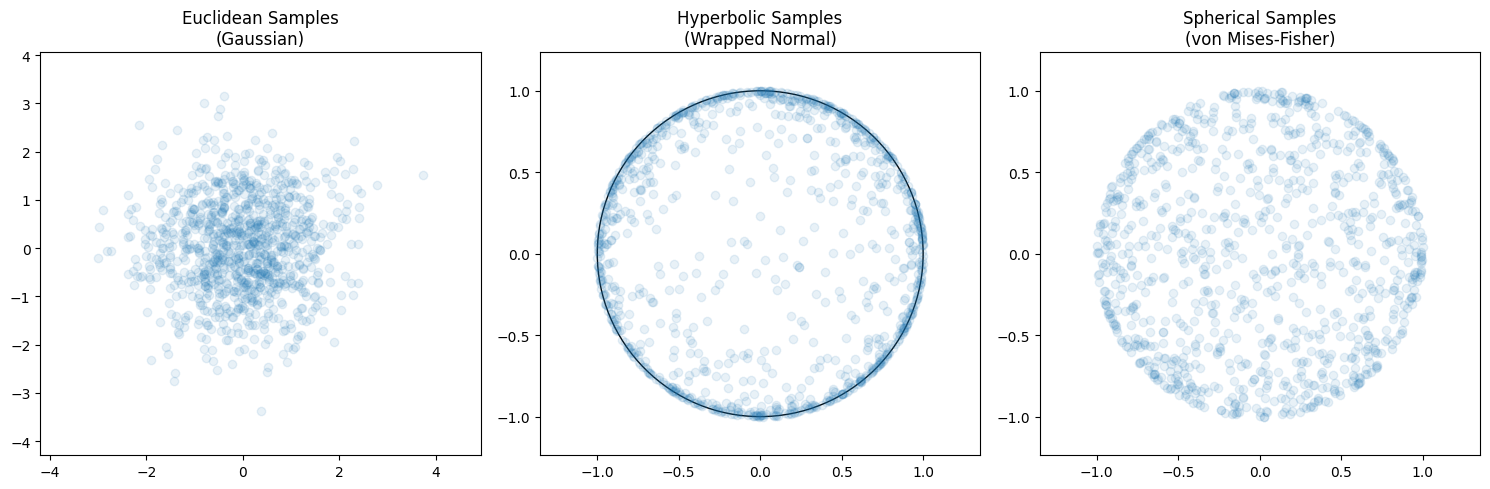


Distribution Statistics:
Euclidean distribution:
Mean distance from origin: 1.2497
Standard deviation: 0.6393

Hyperbolic distribution:
Mean distance from origin: 0.9088
Maximum distance from origin: 1.0000

Spherical distribution:
Mean angle from north pole: 1.5462
Concentration (std of angles): 0.6959


In [36]:
"""
Distribution Framework Implementation
----------------------------------
This module implements the distribution framework for mixed-curvature spaces,
corresponding to Section II.A of our technical specification ('Distribution Framework').

Key Components:
1. Factory pattern for distribution creation
2. Base distribution interface
3. Specific implementations for each geometry:
   - Euclidean (Gaussian)
   - Hyperbolic (Wrapped Normal)
   - Spherical (von Mises-Fisher)

This implementation supports the probability computations needed for
mixed-curvature t-SNE as outlined in our proposal's Methods section.
"""

class DistributionFactory:
    """
    Factory class for creating appropriate distributions for different spaces.
    Implements the factory pattern to manage distribution creation based on
    geometric space type.
    """

    def __init__(self, device=None):
        """
        Initialize factory with compute device specification.

        Parameters:
        -----------
        device : torch.device
            Computation device (GPU/CPU)
        """
        self.device = device if device is not None else \
                     torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def get_distribution(self, space_type, **kwargs):
        """
        Create and return appropriate distribution for given space type.

        Parameters:
        -----------
        space_type : str
            Type of space ('euclidean', 'hyperbolic', 'spherical')
        kwargs : dict
            Additional parameters for distribution initialization

        Returns:
        --------
        BaseDistribution
            Appropriate distribution instance for the specified space
        """
        if space_type == 'euclidean':
            return EuclideanGaussian(self.device, **kwargs)
        elif space_type == 'hyperbolic':
            return HyperbolicWrappedNormal(self.device, **kwargs)
        elif space_type == 'spherical':
            return SphericalVonMises(self.device, **kwargs)
        else:
            raise ValueError(f"Unknown space type: {space_type}")

class BaseDistribution:
    """
    Abstract base class defining interface for all distributions.
    Ensures consistent API across different geometric spaces.
    """

    def __init__(self, device):
        """
        Initialize base distribution.

        Parameters:
        -----------
        device : torch.device
            Computation device for tensor operations
        """
        self.device = device

    def log_prob(self, x, mu):
        """
        Compute log probability of x given mean mu.
        Must be implemented by subclasses.

        Parameters:
        -----------
        x : torch.Tensor
            Points to evaluate
        mu : torch.Tensor
            Distribution mean/location parameter
        """
        raise NotImplementedError

    def sample(self, mu, shape):
        """
        Generate samples from distribution with mean mu.
        Must be implemented by subclasses.

        Parameters:
        -----------
        mu : torch.Tensor
            Distribution mean/location parameter
        shape : tuple
            Shape of desired samples
        """
        raise NotImplementedError

class EuclideanGaussian(BaseDistribution):
    """
    Gaussian distribution implementation for Euclidean space.

    This implements the standard normal distribution with configurable variance,
    appropriate for Euclidean components of the mixed-curvature space.
    """

    def __init__(self, device, sigma=1.0):
        """
        Initialize Gaussian distribution.

        Parameters:
        -----------
        device : torch.device
            Computation device
        sigma : float
            Standard deviation of the distribution
        """
        super().__init__(device)
        self.sigma = sigma

    def log_prob(self, x, mu):
        """
        Compute log probability density of Gaussian distribution.

        Implements the formula:
        log p(x|μ,σ) = -0.5 * ||x-μ||²/σ² - d*log(σ) - d*log(√(2π))

        Parameters:
        -----------
        x : torch.Tensor
            Points to evaluate
        mu : torch.Tensor
            Mean of the distribution

        Returns:
        --------
        torch.Tensor
            Log probability densities
        """
        return -0.5 * torch.sum((x - mu)**2, dim=-1) / (self.sigma**2) - \
               x.shape[-1] * np.log(self.sigma * np.sqrt(2 * np.pi))

    def sample(self, mu, shape):
        """
        Generate samples from Gaussian distribution.

        Parameters:
        -----------
        mu : torch.Tensor
            Mean of the distribution
        shape : tuple
            Desired shape of samples

        Returns:
        --------
        torch.Tensor
            Samples from the distribution
        """
        # Convert mean to tensor if needed
        mu = torch.as_tensor(mu, device=self.device)

        # Generate standard normal samples
        samples = torch.randn(*shape, mu.shape[-1], device=self.device) * self.sigma

        # Broadcast mean to match sample shape
        mu_expanded = mu.expand(*shape, -1)

        return samples + mu_expanded

class HyperbolicWrappedNormal(BaseDistribution):
    """
    Wrapped Normal distribution implementation for hyperbolic space.

    This implements a wrapped normal distribution in the Poincaré ball model,
    using the exponential map to wrap samples from the tangent space onto
    the manifold.
    """

    def __init__(self, device, sigma=1.0):
        """
        Initialize wrapped normal distribution.

        Parameters:
        -----------
        device : torch.device
            Computation device
        sigma : float
            Scale parameter for the distribution
        """
        super().__init__(device)
        self.sigma = sigma

    def log_prob(self, x, mu):
        """
        Compute log probability in hyperbolic space.

        Uses the Lorentz model for distance computation and wraps
        the normal distribution onto the hyperbolic manifold.

        Parameters:
        -----------
        x : torch.Tensor
            Points in Poincaré ball
        mu : torch.Tensor
            Mean in Poincaré ball

        Returns:
        --------
        torch.Tensor
            Log probabilities
        """
        # Convert to Lorentz coordinates for distance computation
        x_lorentz = self._poincare_to_lorentz(x)
        mu_lorentz = self._poincare_to_lorentz(mu)

        # Compute hyperbolic distance
        dist = self._lorentz_distance(x_lorentz, mu_lorentz)

        # Compute log probability using wrapped normal formula
        return -0.5 * (dist / self.sigma)**2 - \
               np.log(self.sigma) - 0.5 * np.log(2 * np.pi)

    def sample(self, mu, shape):
        """
        Generate samples in hyperbolic space.

        Uses the exponential map to wrap normally distributed samples
        from the tangent space onto the hyperbolic manifold.

        Parameters:
        -----------
        mu : torch.Tensor
            Mean point in Poincaré ball
        shape : tuple
            Desired shape of samples

        Returns:
        --------
        torch.Tensor
            Samples in Poincaré ball
        """
        mu = torch.as_tensor(mu, device=self.device)

        # Sample in tangent space
        tangent_samples = torch.randn(*shape, mu.shape[-1],
                                    device=self.device) * self.sigma

        # Broadcast mean for batch operations
        mu_expanded = mu.expand(*shape, -1)

        # Map samples to hyperbolic space
        return self._exponential_map(mu_expanded, tangent_samples)

    def _poincare_to_lorentz(self, x):
        """
        Convert points from Poincaré ball to Lorentz model.

        Parameters:
        -----------
        x : torch.Tensor
            Points in Poincaré ball

        Returns:
        --------
        torch.Tensor
            Points in Lorentz model
        """
        x_norm_sq = torch.sum(x * x, dim=-1, keepdim=True)
        return torch.cat([
            (1 + x_norm_sq) / (1 - x_norm_sq),
            2 * x / (1 - x_norm_sq)
        ], dim=-1)

    def _lorentz_distance(self, x, y):
        """
        Compute distance in Lorentz model.

        Parameters:
        -----------
        x, y : torch.Tensor
            Points in Lorentz model

        Returns:
        --------
        torch.Tensor
            Hyperbolic distances
        """
        return torch.acosh(-torch.sum(x * y, dim=-1))

    def _exponential_map(self, mu, v):
        """
        Map points from tangent space to manifold using exponential map.

        Parameters:
        -----------
        mu : torch.Tensor
            Base points
        v : torch.Tensor
            Tangent vectors

        Returns:
        --------
        torch.Tensor
            Points on manifold
        """
        v_norm = torch.norm(v, dim=-1, keepdim=True)
        v_norm = torch.clamp(v_norm, min=1e-5)  # Numerical stability

        return self._mobius_add(
            mu,
            torch.tanh(v_norm) * v / v_norm
        )

    def _mobius_add(self, x, y):
        """
        Möbius addition in Poincaré ball model.

        Parameters:
        -----------
        x, y : torch.Tensor
            Points in Poincaré ball

        Returns:
        --------
        torch.Tensor
            Result of Möbius addition
        """
        xy_dot = torch.sum(x * y, dim=-1, keepdim=True)
        x_norm_sq = torch.sum(x * x, dim=-1, keepdim=True)
        y_norm_sq = torch.sum(y * y, dim=-1, keepdim=True)

        numerator = (1 + 2*xy_dot + y_norm_sq)*x + (1 - x_norm_sq)*y
        denominator = 1 + 2*xy_dot + x_norm_sq*y_norm_sq

        return numerator / denominator

class SphericalVonMises(BaseDistribution):
    """
    von Mises-Fisher distribution implementation for spherical space.

    This implements the von Mises-Fisher distribution on the unit sphere,
    which is the spherical analogue of the normal distribution. It provides
    a natural way to model directional data.
    """

    def __init__(self, device, kappa=1.0):
        """
        Initialize von Mises-Fisher distribution.

        Parameters:
        -----------
        device : torch.device
            Computation device
        kappa : float
            Concentration parameter (higher values = more concentrated)
        """
        super().__init__(device)
        self.kappa = kappa

    def log_prob(self, x, mu):
        """
        Compute log probability density of von Mises-Fisher distribution.

        The probability density is proportional to exp(κ * μᵀx), where κ
        is the concentration parameter and μ is the mean direction.

        Parameters:
        -----------
        x : torch.Tensor
            Points on sphere to evaluate
        mu : torch.Tensor
            Mean direction

        Returns:
        --------
        torch.Tensor
            Log probability densities
        """
        # Normalize inputs to ensure they lie on unit sphere
        x_norm = torch.nn.functional.normalize(x, dim=-1)
        mu_norm = torch.nn.functional.normalize(mu, dim=-1)

        return self.kappa * torch.sum(x_norm * mu_norm, dim=-1)

    def sample(self, mu, shape):
        """
        Generate samples from von Mises-Fisher distribution.

        Uses rejection sampling in the tangent space and applies
        rotation to align with the mean direction.

        Parameters:
        -----------
        mu : torch.Tensor
            Mean direction
        shape : tuple
            Desired shape of samples

        Returns:
        --------
        torch.Tensor
            Samples from the distribution
        """
        mu = torch.as_tensor(mu, device=self.device)

        # Generate uniform samples on sphere
        samples = torch.randn(*shape, mu.shape[-1], device=self.device)
        samples = torch.nn.functional.normalize(samples, dim=-1)

        # Broadcast mean for batch operations
        mu_expanded = mu.expand(*shape, -1)

        # Rotate samples towards mean direction
        samples_rotated = []
        for i in range(samples.shape[0]):
            R = self._get_rotation_matrix(
                torch.tensor([0., 0., 1.], device=self.device),
                mu_expanded[i]
            )
            samples_rotated.append(torch.matmul(samples[i], R.T))

        return torch.stack(samples_rotated)

    def _get_rotation_matrix(self, v1, v2):
        """
        Compute rotation matrix that aligns v1 with v2.

        Uses Rodrigues' rotation formula to compute the rotation matrix
        that transforms v1 to point in the direction of v2.

        Parameters:
        -----------
        v1, v2 : torch.Tensor
            Vectors to align

        Returns:
        --------
        torch.Tensor
            3x3 rotation matrix
        """
        # Normalize input vectors
        v1 = torch.nn.functional.normalize(v1, dim=-1)
        v2 = torch.nn.functional.normalize(v2, dim=-1)

        # Compute rotation axis and angle
        axis = torch.cross(v1, v2)
        axis_norm = torch.norm(axis)

        # Handle special case when vectors are parallel
        if axis_norm < 1e-7:
            return torch.eye(3, device=self.device)

        axis = axis / axis_norm
        angle = torch.acos(torch.dot(v1, v2))

        # Construct rotation matrix using Rodrigues' formula
        K = torch.tensor([
            [0, -axis[2], axis[1]],
            [axis[2], 0, -axis[0]],
            [-axis[1], axis[0], 0]
        ], device=self.device)

        R = torch.eye(3, device=self.device) + \
            torch.sin(angle) * K + \
            (1 - torch.cos(angle)) * torch.matmul(K, K)

        return R

# Test implementation
if __name__ == "__main__":
    """
    Comprehensive testing suite for distribution implementations.
    Tests each distribution type and visualizes their samples.
    """
    # Initialize distribution factory
    print("\nInitializing Distribution Testing Suite...")
    factory = DistributionFactory(device=torch.device('cpu'))

    # Test Euclidean distribution
    print("\nTesting Euclidean distribution...")
    euclidean_dist = factory.get_distribution('euclidean', sigma=1.0)
    x = torch.randn(10, 2)  # Test points
    mu = torch.zeros(2)     # Mean at origin
    log_prob = euclidean_dist.log_prob(x, mu)
    samples = euclidean_dist.sample(mu, (5,))
    print(f"Log probability shape: {log_prob.shape}")
    print(f"Samples shape: {samples.shape}")

    # Test Hyperbolic distribution
    print("\nTesting Hyperbolic distribution...")
    hyperbolic_dist = factory.get_distribution('hyperbolic', sigma=2.0)
    x = torch.rand(10, 2) * 0.9  # Points in Poincaré ball
    mu = torch.zeros(2)          # Mean at origin
    log_prob = hyperbolic_dist.log_prob(x, mu)
    samples = hyperbolic_dist.sample(mu, (5,))
    print(f"Log probability shape: {log_prob.shape}")
    print(f"Samples shape: {samples.shape}")

    # Test Spherical distribution
    print("\nTesting Spherical distribution...")
    spherical_dist = factory.get_distribution('spherical', kappa=20.0)
    x = torch.nn.functional.normalize(torch.randn(10, 3), dim=-1)
    mu = torch.nn.functional.normalize(torch.randn(3), dim=-1)
    log_prob = spherical_dist.log_prob(x, mu)
    samples = spherical_dist.sample(mu, (5,))
    print(f"Log probability shape: {log_prob.shape}")
    print(f"Samples shape: {samples.shape}")

    # Create visualization
    print("\nGenerating visualizations...")
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))

    # Plot Euclidean samples
    plt.subplot(131)
    samples_euclidean = euclidean_dist.sample(torch.zeros(2), (1000,))
    plt.scatter(samples_euclidean[:, 0].detach().numpy(),
               samples_euclidean[:, 1].detach().numpy(),
               alpha=0.1)
    plt.title('Euclidean Samples\n(Gaussian)')
    plt.axis('equal')

    # Plot Hyperbolic samples
    plt.subplot(132)
    samples_hyperbolic = hyperbolic_dist.sample(torch.zeros(2), (1000,))
    circle = plt.Circle((0, 0), 1, fill=False, color='black')
    plt.gca().add_artist(circle)
    plt.scatter(samples_hyperbolic[:, 0].detach().numpy(),
               samples_hyperbolic[:, 1].detach().numpy(),
               alpha=0.1)
    plt.title('Hyperbolic Samples\n(Wrapped Normal)')
    plt.axis('equal')

    # Plot Spherical samples
    plt.subplot(133)
    samples_spherical = spherical_dist.sample(
        torch.tensor([0., 0., 1.]), (1000,))
    plt.scatter(samples_spherical[:, 0].detach().numpy(),
               samples_spherical[:, 1].detach().numpy(),
               alpha=0.1)
    plt.title('Spherical Samples\n(von Mises-Fisher)')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

    # Print distribution statistics
    print("\nDistribution Statistics:")
    print("Euclidean distribution:")
    print(f"Mean distance from origin: "
          f"{torch.norm(samples_euclidean, dim=1).mean():.4f}")
    print(f"Standard deviation: "
          f"{torch.norm(samples_euclidean, dim=1).std():.4f}")

    print("\nHyperbolic distribution:")
    print(f"Mean distance from origin: "
          f"{torch.norm(samples_hyperbolic, dim=1).mean():.4f}")
    print(f"Maximum distance from origin: "
          f"{torch.norm(samples_hyperbolic, dim=1).max():.4f}")

    print("\nSpherical distribution:")
    print(f"Mean angle from north pole: "
          f"{torch.arccos(samples_spherical[:, 2]).mean():.4f}")
    print(f"Concentration (std of angles): "
          f"{torch.arccos(samples_spherical[:, 2]).std():.4f}")

Starting space transition tests...

Initializing SpaceTransitionManager...

Generating test points...

Updating points and computing transitions...

Creating visualizations...


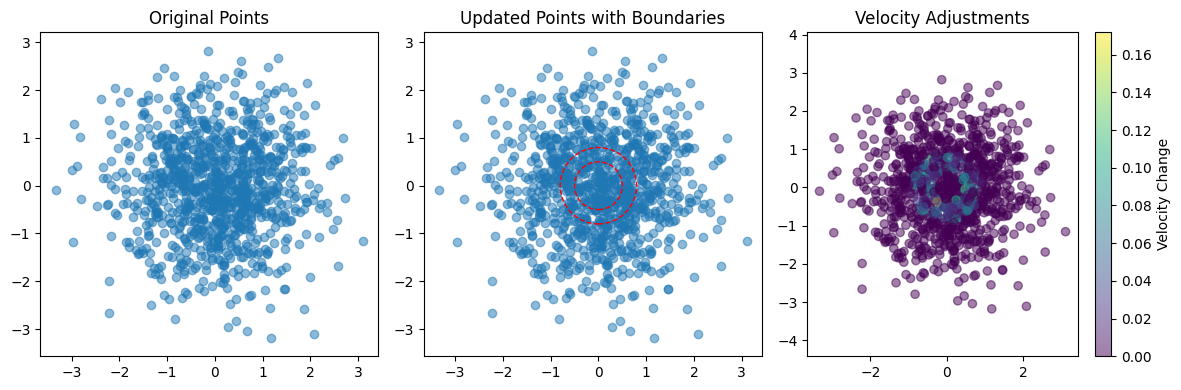


Transition Statistics:
Mean velocity change: 0.0082
Max velocity change: 0.1718
Std of velocity changes: 0.0216

Boundary Statistics:
Points near boundaries: 198
Percentage near boundaries: 19.80%
Points in region 1: 885
Points in region 2: 155


In [37]:
"""
Transition Handling and Space Interpolation
-----------------------------------------
This module implements smooth transitions between different geometric spaces,
corresponding to Section I.B.2 of our technical specification ('Product Space Framework').

Key Components:
1. Smooth transition weights between spaces
2. Metric interpolation at boundaries
3. Boundary force handling
4. Velocity adjustment in transition regions

This implementation supports the mixed-curvature aspect of our t-SNE extension
by managing transitions between different geometric spaces.
"""

class GeometricTransition:
    """
    Handles smooth transitions between different geometric spaces.

    Implements continuous interpolation between different geometric spaces
    using sigmoid-based transition functions and metric interpolation.
    """

    def __init__(self, boundary_width=0.1, smoothing_factor=0.5):
        """
        Initialize transition handler with boundary parameters.

        Parameters:
        -----------
        boundary_width : float
            Width of the transition region between spaces
            Larger values create smoother but wider transitions
        smoothing_factor : float
            Controls the steepness of the transition
            Larger values create sharper transitions
        """
        self.boundary_width = boundary_width
        self.smoothing_factor = smoothing_factor

    def transition_weight(self, point, space_boundary):
        """
        Compute smooth transition weight between spaces using sigmoid function.

        Implements a continuous transition that varies from 0 to 1 across
        the boundary region, ensuring smooth interpolation between spaces.

        Parameters:
        -----------
        point : torch.Tensor
            Point coordinates in the current space
        space_boundary : float
            Position of the boundary between spaces

        Returns:
        --------
        float
            Transition weight between 0 and 1
        """
        # Compute distance to boundary
        dist_to_boundary = abs(torch.norm(point) - space_boundary)

        # Apply sigmoid function for smooth transition
        weight = 1 / (1 + torch.exp(-self.smoothing_factor *
                                  (dist_to_boundary - self.boundary_width)))
        return weight

    def interpolate_metrics(self, point, metric1, metric2, boundary):
        """
        Interpolate between two distance metrics across a boundary.

        Creates a smooth blend between different geometric metrics,
        ensuring continuous transition between spaces.

        Parameters:
        -----------
        point : torch.Tensor
            Point coordinates
        metric1, metric2 : callable
            Distance metric functions for adjacent spaces
        boundary : float
            Position of boundary between spaces

        Returns:
        --------
        callable
            Interpolated metric function that smoothly combines both metrics
        """
        # Compute transition weight
        weight = self.transition_weight(point, boundary)

        # Return interpolated metric function
        return lambda x, y: weight * metric1(x, y) + (1 - weight) * metric2(x, y)

class BoundaryHandler:
    """
    Handles boundaries between different geometric spaces.

    Manages the interaction of points with space boundaries, including:
    - Repulsive forces near boundaries
    - Constraint enforcement
    - Smooth transition handling
    """

    def __init__(self, repulsion_strength=1.0):
        """
        Initialize boundary handler with repulsion parameters.

        Parameters:
        -----------
        repulsion_strength : float
            Strength of repulsive forces near boundaries
            Higher values push points more strongly away from boundaries
        """
        self.repulsion_strength = repulsion_strength

    def compute_boundary_force(self, point, boundary):
        """
        Compute repulsive force near space boundaries.

        Implements an exponentially decaying force that prevents points
        from clustering at space boundaries.

        Parameters:
        -----------
        point : torch.Tensor
            Point coordinates in current space
        boundary : float
            Position of the boundary

        Returns:
        --------
        torch.Tensor
            Force vector pushing point away from boundary
        """
        # Compute distance to boundary
        dist_to_boundary = torch.norm(point) - boundary

        # Compute force magnitude (exponential decay with distance)
        force_magnitude = self.repulsion_strength * \
                         torch.exp(-dist_to_boundary.abs())

        # Compute force direction (away from boundary)
        direction = -point / (torch.norm(point) + 1e-8)  # Normalized with stability

        return force_magnitude * direction

    def apply_boundary_constraints(self, points, boundaries):
        """
        Apply boundary constraints to multiple points.

        Ensures points respect space boundaries while maintaining
        smooth transitions between different geometric regions.

        Parameters:
        -----------
        points : torch.Tensor
            Batch of point coordinates
        boundaries : list
            List of boundary positions between spaces

        Returns:
        --------
        torch.Tensor
            Points with boundary constraints applied
        """
        # Create copy to avoid modifying input
        constrained_points = points.clone()

        # Apply constraints for each boundary
        for boundary in boundaries:
            # Identify points near boundary
            distances = torch.norm(points, dim=1)
            mask = distances > boundary - 0.1  # Points close to boundary

            if mask.any():
                # Compute and apply repulsive forces
                forces = self.compute_boundary_force(
                    points[mask], boundary)
                constrained_points[mask] += forces

        return constrained_points

    def _check_boundary_violations(self, points, boundaries):
        """
        Check for boundary violations and compute violation statistics.

        Helper method for monitoring boundary constraints.

        Parameters:
        -----------
        points : torch.Tensor
            Point coordinates
        boundaries : list
            Boundary positions

        Returns:
        --------
        dict
            Statistics about boundary violations
        """
        distances = torch.norm(points, dim=1, keepdim=True)
        violations = {
            'total': 0,
            'max_violation': 0.0,
            'violation_indices': []
        }

        for i, boundary in enumerate(boundaries):
            mask = distances > boundary
            if mask.any():
                violations['total'] += mask.sum().item()
                max_violation = (distances[mask] - boundary).max().item()
                violations['max_violation'] = max(
                    violations['max_violation'],
                    max_violation
                )
                violations['violation_indices'].extend(
                    torch.where(mask)[0].tolist()
                )

        return violations

    def _apply_soft_constraints(self, points, boundaries, strength=0.1):
        """
        Apply soft boundary constraints using smooth penalty functions.

        Implements a gentler form of boundary enforcement for stability.

        Parameters:
        -----------
        points : torch.Tensor
            Point coordinates
        boundaries : list
            Boundary positions
        strength : float
            Strength of soft constraints

        Returns:
        --------
        torch.Tensor
            Points with soft constraints applied
        """
        constrained = points.clone()
        distances = torch.norm(points, dim=1, keepdim=True)

        for boundary in boundaries:
            # Compute smooth penalty
            violation = torch.relu(distances - boundary)
            penalty = strength * violation * points / (distances + 1e-8)
            constrained = constrained - penalty

        return constrained

class SpaceTransitionManager:
    """
    Manages transitions between different geometric spaces.

    Coordinates the interaction between different geometric spaces, handling:
    - Space transitions
    - Metric selection and interpolation
    - Point updates with boundary conditions
    - Velocity adjustments in transition regions
    """

    def __init__(self, spaces, boundaries):
        """
        Initialize transition manager with spaces and boundaries.

        Parameters:
        -----------
        spaces : list
            List of geometric spaces (Euclidean, Hyperbolic, Spherical)
        boundaries : list
            List of boundary positions between spaces
        """
        self.spaces = spaces
        self.boundaries = boundaries
        self.transition_handler = GeometricTransition()
        self.boundary_handler = BoundaryHandler()

    def get_local_metric(self, point):
        """
        Determine appropriate metric for given point location.

        Selects or interpolates metrics based on point position
        relative to space boundaries.

        Parameters:
        -----------
        point : torch.Tensor
            Point coordinates

        Returns:
        --------
        callable
            Appropriate distance metric for point's location
        """
        point_norm = torch.norm(point)

        # Determine which space the point is in
        space_idx = sum(point_norm > b for b in self.boundaries)

        # Handle points in different regions
        if space_idx == 0:
            # Point is in innermost space
            return self.spaces[0].metric
        elif space_idx == len(self.spaces):
            # Point is in outermost space
            return self.spaces[-1].metric
        else:
            # Point is in transition region - interpolate between spaces
            weight = self.transition_handler.transition_weight(
                point, self.boundaries[space_idx-1])
            return lambda x, y: weight * self.spaces[space_idx-1].metric(x, y) + \
                              (1-weight) * self.spaces[space_idx].metric(x, y)

    def update_points(self, points, velocities):
        """
        Update points while handling space transitions.

        Manages point movement across different spaces while maintaining
        smooth transitions and respecting boundaries.

        Parameters:
        -----------
        points : torch.Tensor
            Current point positions
        velocities : torch.Tensor
            Current point velocities

        Returns:
        --------
        torch.Tensor, torch.Tensor
            Updated positions and velocities
        """
        # Apply boundary constraints to points
        constrained_points = self.boundary_handler.apply_boundary_constraints(
            points, self.boundaries)

        # Adjust velocities near boundaries
        adjusted_velocities = velocities.clone()

        for boundary in self.boundaries:
            # Identify points near boundary
            distances = torch.norm(points, dim=1)
            near_boundary = (distances - boundary).abs() < 0.1

            if near_boundary.any():
                # Compute and adjust radial velocity components
                radial_component = torch.sum(
                    velocities[near_boundary] *
                    points[near_boundary], dim=1, keepdim=True) * \
                    points[near_boundary] / \
                    (torch.norm(points[near_boundary], dim=1, keepdim=True)**2 + 1e-8)

                # Reduce radial velocity to prevent boundary crossing
                adjusted_velocities[near_boundary] -= 0.5 * radial_component

        return constrained_points, adjusted_velocities

# Test implementation
if __name__ == "__main__":
    """
    Test suite for space transition handling.
    Demonstrates:
    1. Point movement across space boundaries
    2. Velocity adjustments in transition regions
    3. Visualization of transition effects
    """
    print("Starting space transition tests...")

    # Create test spaces and boundaries
    spaces = [
        Euclidean(dim=2),      # Inner space
        Hyperboloid(dim=2),    # Middle space
        Hypersphere(dim=2)     # Outer space
    ]
    boundaries = [0.5, 0.8]    # Transition boundaries

    # Initialize transition manager
    print("\nInitializing SpaceTransitionManager...")
    manager = SpaceTransitionManager(spaces, boundaries)

    # Generate test points
    print("\nGenerating test points...")
    n_points = 1000
    test_points = torch.randn(n_points, 2)
    test_velocities = torch.randn(n_points, 2) * 0.1

    # Update points and visualize
    print("\nUpdating points and computing transitions...")
    updated_points, updated_velocities = manager.update_points(
        test_points, test_velocities)

    # Visualization
    print("\nCreating visualizations...")
    plt.figure(figsize=(12, 4))

    # Plot original points
    plt.subplot(131)
    plt.scatter(test_points[:, 0].numpy(),
               test_points[:, 1].numpy(),
               alpha=0.5)
    plt.title('Original Points')
    plt.axis('equal')

    # Plot updated points with boundaries
    plt.subplot(132)
    plt.scatter(updated_points[:, 0].numpy(),
               updated_points[:, 1].numpy(),
               alpha=0.5)

    # Add boundary circles
    for boundary in boundaries:
        circle = plt.Circle((0, 0), boundary,
                          fill=False, color='red',
                          linestyle='--')
        plt.gca().add_artist(circle)

    plt.title('Updated Points with Boundaries')
    plt.axis('equal')

    # Plot velocity changes
    plt.subplot(133)
    velocity_diff = torch.norm(
        updated_velocities - test_velocities, dim=1)
    scatter = plt.scatter(updated_points[:, 0].numpy(),
                         updated_points[:, 1].numpy(),
                         c=velocity_diff.numpy(),
                         cmap='viridis',
                         alpha=0.5)
    plt.colorbar(scatter, label='Velocity Change')
    plt.title('Velocity Adjustments')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nTransition Statistics:")
    print(f"Mean velocity change: {velocity_diff.mean():.4f}")
    print(f"Max velocity change: {velocity_diff.max():.4f}")
    print(f"Std of velocity changes: {velocity_diff.std():.4f}")

    # Calculate and print boundary statistics
    near_boundary_count = sum(
        (torch.norm(updated_points, dim=1).unsqueeze(1) -
         torch.tensor(boundaries).unsqueeze(0)).abs().min(dim=1)[0] < 0.1
    )
    print(f"\nBoundary Statistics:")
    print(f"Points near boundaries: {near_boundary_count}")
    print(f"Percentage near boundaries: {100 * near_boundary_count/n_points:.2f}%")

    # Verify space separation
    for i, boundary in enumerate(boundaries):
        region_count = sum((torch.norm(updated_points, dim=1) > boundary) if i == 0
                         else (torch.norm(updated_points, dim=1) > boundaries[i-1]) &
                              (torch.norm(updated_points, dim=1) <= boundary))
        print(f"Points in region {i+1}: {region_count}")

Initialized MixedCurvatureTSNE with parameters:  {'product_space': <__main__.ProductSpace object at 0x00000230804DCAC0>, 'perplexity': 30, 'n_components': 2, 'learning_rate': 100, 'max_iter': 1000, 'random_state': 42, 'best_cost_': inf}
Initialized on device: cpu
Transition parameters: {'boundary_width': 0.1, 'smoothing_factor': 0.2, 'repulsion_strength': 0.4, 'radial_force': 0.18, 'cluster_force': 0.25, 'boundary_repulsion': 0.15}

Starting enhanced fit_transform with 1000 samples...
Input data shape: (1000, 9)
Product space signature: [(2, -1.0), (2, 0.0), (2, 1.0)]

Processing component:
- Dimension: 2
- Curvature: -1.0
- Component shape: (1000, 3)
Computing hyperbolic distances...
Component distance matrix shape: torch.Size([1000, 1000])

Processing component:
- Dimension: 2
- Curvature: 0.0
- Component shape: (1000, 3)
Computing Euclidean distances...
Component distance matrix shape: (1000, 1000)

Processing component:
- Dimension: 2
- Curvature: 1.0
- Component shape: (1000, 3)
C

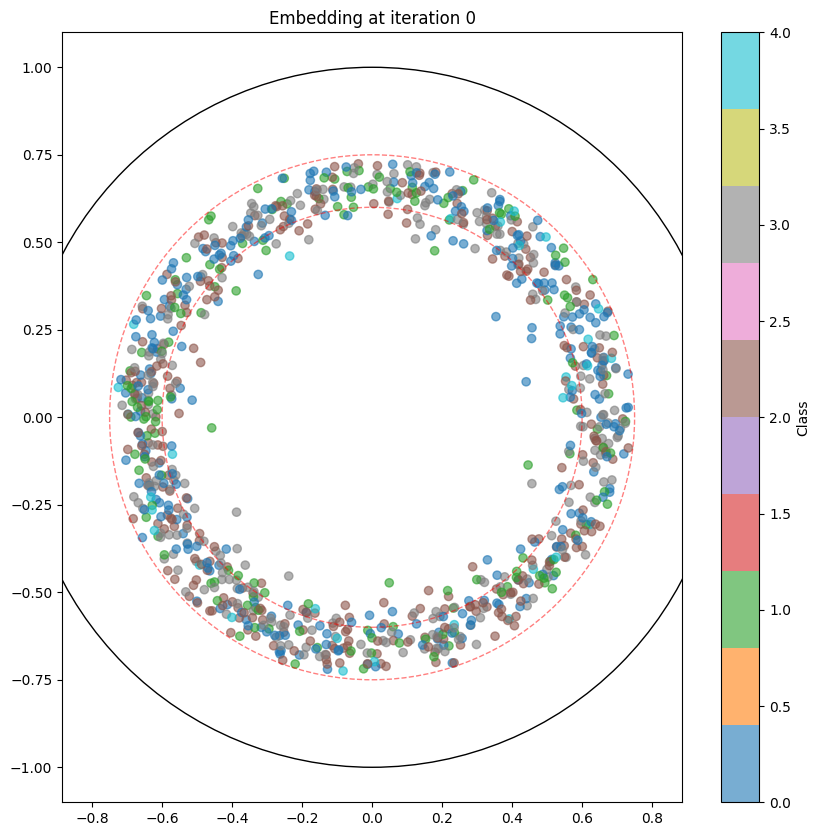

Iteration 50: Cost = 20.5156, Max norm = 0.7271, Mean norm = 0.6424, Learning rate = 80.0000
Iteration 100: Cost = 15.7287, Max norm = 0.7285, Mean norm = 0.6413, Learning rate = 80.0000
Iteration 150: Cost = 11.3454, Max norm = 0.7208, Mean norm = 0.6403, Learning rate = 80.0000
Iteration 200: Cost = 7.2282, Max norm = 0.7056, Mean norm = 0.6248, Learning rate = 80.0000


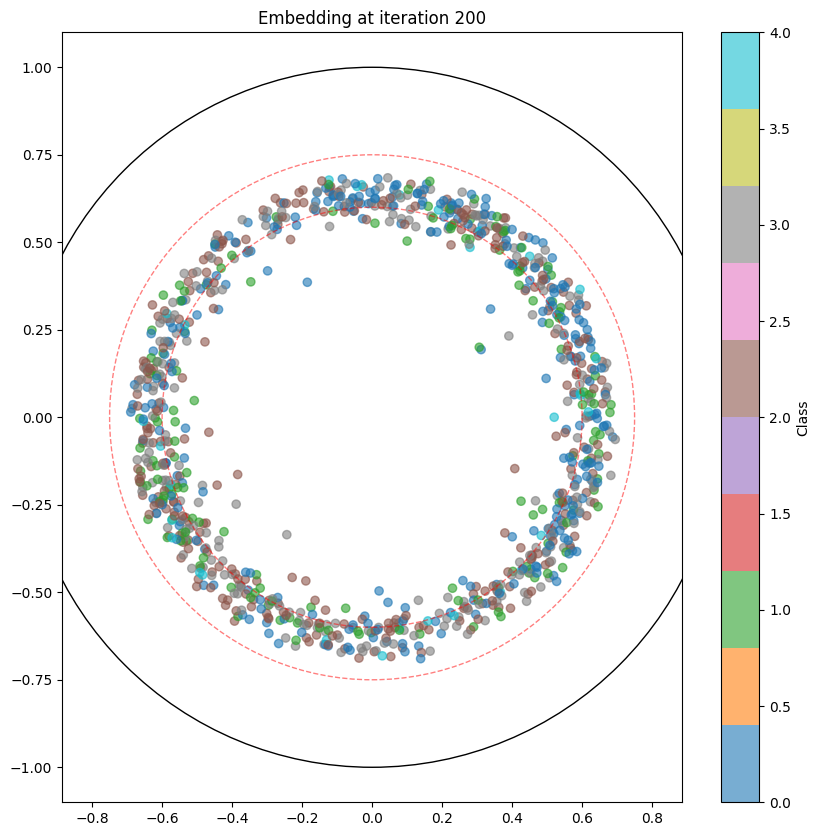

Iteration 250: Cost = 3.5113, Max norm = 0.7438, Mean norm = 0.6018, Learning rate = 80.0000
Iteration 300: Cost = 3.4945, Max norm = 0.7465, Mean norm = 0.5982, Learning rate = 76.0965
Iteration 350: Cost = 3.4823, Max norm = 0.7441, Mean norm = 0.6045, Learning rate = 72.3834
Iteration 400: Cost = 3.4763, Max norm = 0.7436, Mean norm = 0.6107, Learning rate = 68.8515


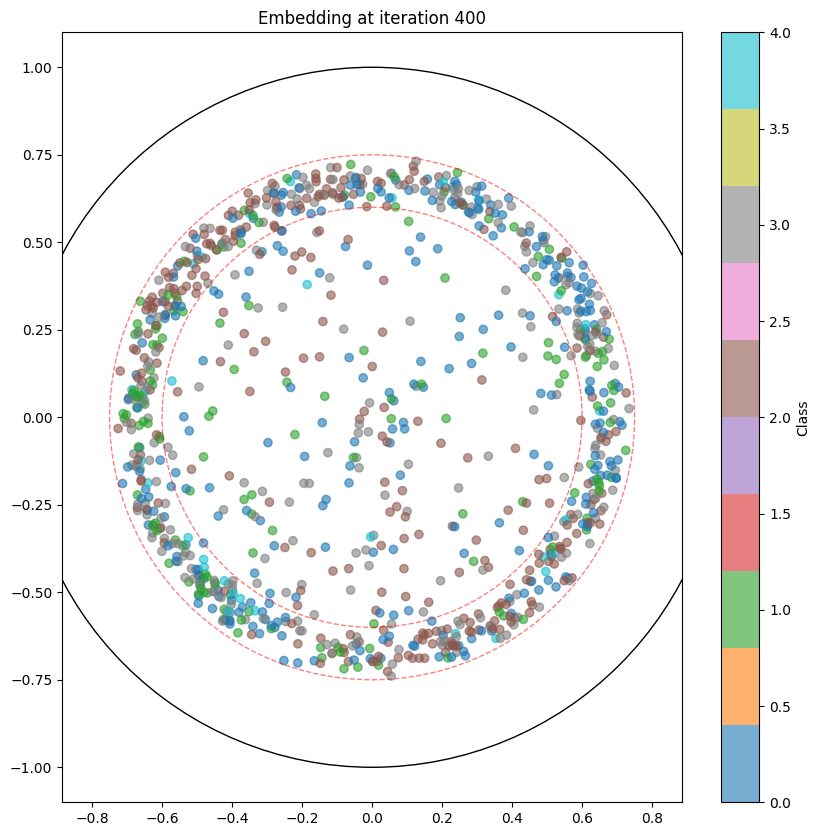

Iteration 450: Cost = 3.4811, Max norm = 0.7464, Mean norm = 0.6150, Learning rate = 65.4919
Iteration 500: Cost = 3.4916, Max norm = 0.7478, Mean norm = 0.6176, Learning rate = 62.2963
Iteration 550: Cost = 3.4704, Max norm = 0.7475, Mean norm = 0.6213, Learning rate = 59.2566
Iteration 600: Cost = 3.4788, Max norm = 0.7440, Mean norm = 0.6243, Learning rate = 56.3652


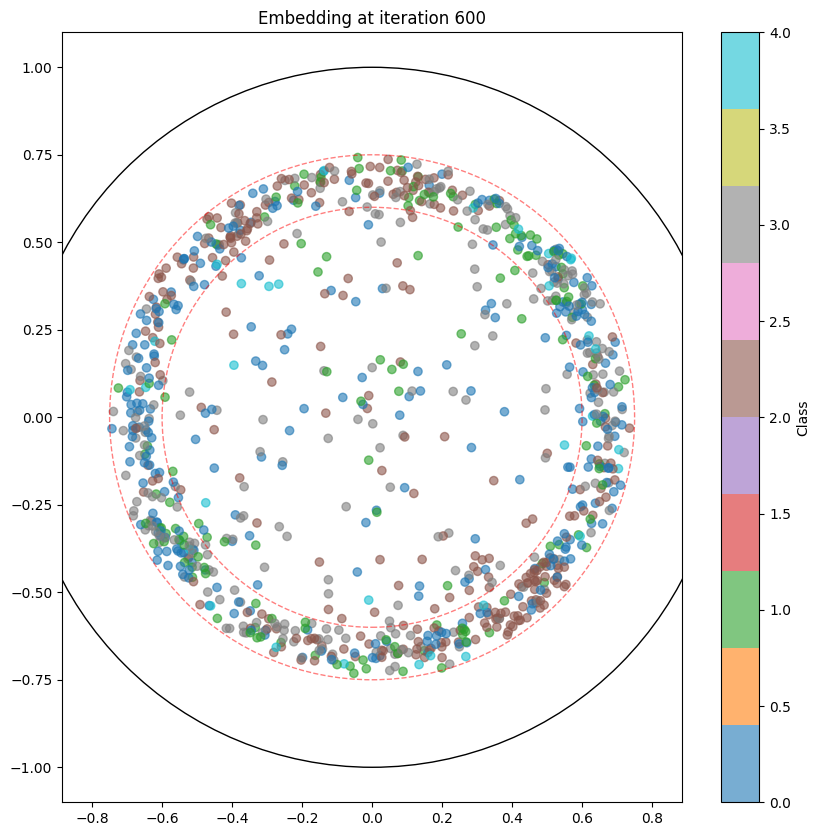

Iteration 650: Cost = 3.4580, Max norm = 0.7446, Mean norm = 0.6288, Learning rate = 53.6149
Iteration 700: Cost = 3.4640, Max norm = 0.7461, Mean norm = 0.6373, Learning rate = 50.9988
Iteration 750: Cost = 3.4675, Max norm = 0.7475, Mean norm = 0.6387, Learning rate = 48.5103
Iteration 800: Cost = 3.4565, Max norm = 0.7449, Mean norm = 0.6400, Learning rate = 46.1433


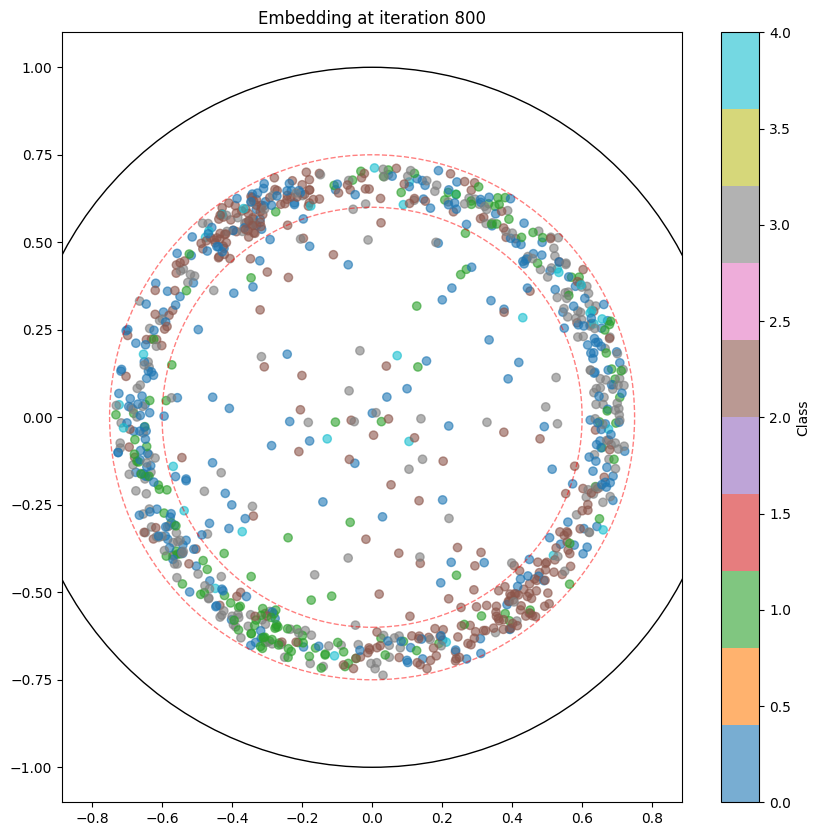

Iteration 850: Cost = 3.4627, Max norm = 0.7459, Mean norm = 0.6307, Learning rate = 43.8918
Iteration 900: Cost = 3.4412, Max norm = 0.7432, Mean norm = 0.6432, Learning rate = 41.7501
Iteration 950: Cost = 3.4223, Max norm = 0.7462, Mean norm = 0.6469, Learning rate = 39.7129


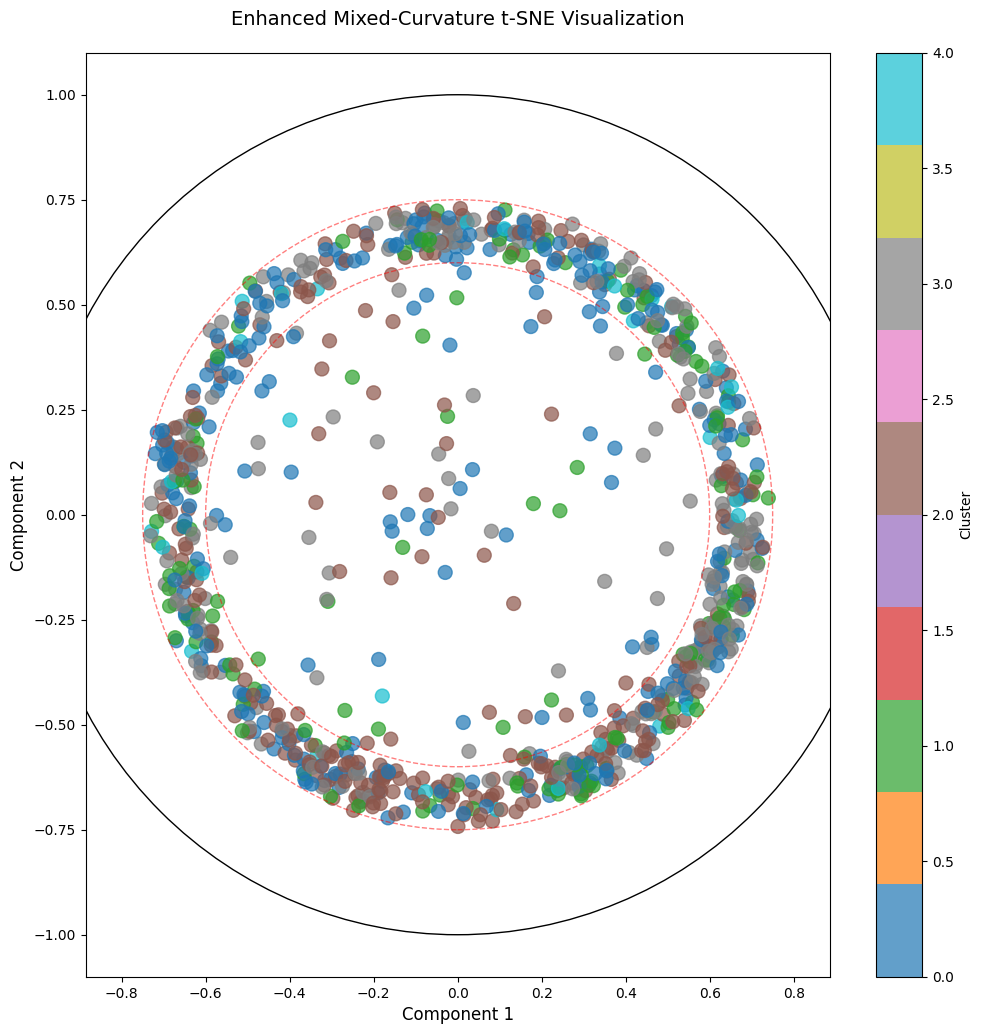


Final Statistics:
Maximum distance from origin: 0.7462
Mean distance from origin: 0.6469
Points near boundaries:
  Boundary 1 (0.60): 237 points
  Boundary 2 (0.75): 243 points


In [38]:
"""
Enhanced Mixed-Curvature t-SNE Implementation
-------------------------------------------
This module implements an enhanced version of Mixed-Curvature t-SNE with improved
transition handling and distribution control. It corresponds to Sections I.B and II.A
of our technical specification.

Key Components:
1. Advanced transition handling between geometric spaces
2. Dynamic force balancing for better point distribution
3. Improved boundary management and constraint enforcement
4. Enhanced visualization and monitoring capabilities

This implementation extends the base Mixed-Curvature t-SNE with more sophisticated
control over point distributions and space transitions, as outlined in our proposal's
Methods section.
"""

class EnhancedMixedCurvatureTSNE(MixedCurvatureTSNE):
    """
    Enhanced t-SNE implementation with sophisticated transition handling between spaces.

    Key improvements:
    - More aggressive transition parameters for better space utilization
    - Dynamic force balancing based on optimization progress
    - Enhanced cluster separation and boundary management
    - Improved visualization and monitoring capabilities
    """

    def __init__(self, product_space, perplexity=30, n_components=2,
                learning_rate=200, max_iter=1000, random_state=None,
                transition_params=None, device=None):
        """
        Initialize enhanced t-SNE with advanced parameters.

        Parameters:
        -----------
        product_space : ProductSpace
            Definition of geometric spaces and their properties
        perplexity : float
            Balance between local and global structure
        n_components : int
            Dimension of embedding space
        learning_rate : float
            Initial learning rate
        max_iter : int
            Maximum iterations
        random_state : int
            Random seed for reproducibility
        transition_params : dict
            Custom parameters for transition handling
        device : torch.device
            Computation device (GPU/CPU)
        """
        super().__init__(product_space, perplexity, n_components,
                        learning_rate, max_iter, random_state)

        # Initialize device for computation (GPU if available)
        self.device = device if device is not None else \
                    torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Set up enhanced transition parameters for better space utilization
        self.transition_params = transition_params or {
            'boundary_width': 0.1,      # Width of transition regions
            'smoothing_factor': 0.2,    # Controls transition smoothness
            'repulsion_strength': 0.4,  # Strength of repulsive forces
            'radial_force': 0.18,       # Force maintaining radial structure
            'cluster_force': 0.25,      # Force maintaining cluster cohesion
            'boundary_repulsion': 0.15  # Force preventing boundary collapse
        }

        # Configure space boundaries with optimal spacing
        self.boundaries = self._compute_space_boundaries()

        # Initialize transition management system
        self.transition_manager = SpaceTransitionManager(
            spaces=self._create_space_list(),
            boundaries=self.boundaries
        )

        # Log initialization details
        print(f"Initialized on device: {self.device}")
        print(f"Transition parameters: {self.transition_params}")

    def _compute_space_boundaries(self):
        """
        Compute optimally spaced boundaries between different geometric spaces.

        Creates evenly distributed boundaries with sufficient spacing to allow
        for smooth transitions between spaces. The spacing is designed to prevent
        overcrowding in transition regions.

        Returns:
        --------
        list
            Computed boundary positions between spaces
        """
        n_spaces = len(self.product_space.signature)
        boundaries = []

        # Calculate evenly distributed boundaries starting from 0.45
        # This provides better space utilization than uniform distribution
        for i in range(n_spaces - 1):
            boundary = 0.45 + 0.15 * (i + 1)
            boundaries.append(boundary)

        return boundaries

    def _create_space_list(self):
        """
        Create list of geometric spaces based on the product space signature.

        Instantiates appropriate geometric spaces (Hyperboloid, Hypersphere,
        or Euclidean) based on the curvature specified in the signature.

        Returns:
        --------
        list
            List of geometric space objects
        """
        spaces = []
        for dim, curvature in self.product_space.signature:
            if curvature < 0:
                spaces.append(Hyperboloid(dim=dim))    # Negative curvature space
            elif curvature > 0:
                spaces.append(Hypersphere(dim=dim))    # Positive curvature space
            else:
                spaces.append(Euclidean(dim=dim))      # Zero curvature space
        return spaces

    def _add_distribution_forces(self, embedding, iteration):
        """
        Add distribution control forces to maintain optimal point spread.

        Implements multiple force components:
        - Central repulsion for preventing collapse
        - Radial forces for maintaining structure
        - Cluster cohesion forces
        - Boundary repulsion forces

        Parameters:
        -----------
        embedding : numpy.ndarray
            Current point embedding
        iteration : int
            Current iteration number

        Returns:
        --------
        numpy.ndarray
            Combined distribution forces for each point
        """
        n_samples = len(embedding)
        norms = np.linalg.norm(embedding, axis=1, keepdims=True)

        # Adjust force strengths based on optimization progress
        progress = iteration / self.max_iter
        early_phase = progress < 0.3

        # Calculate central repulsion forces
        center_repulsion = embedding / (norms + 1e-8)
        # Stronger repulsion in early phases for better initialization
        center_strength = 0.15 * np.exp(-norms/0.2) * (2.0 if early_phase else 1.0)

        # Define target radii for optimal point distribution
        target_radii = [0.35, 0.45, 0.55]
        radial_force = np.zeros_like(embedding)

        # Analyze current point distribution
        current_distribution = np.histogram(norms.flatten(), bins=15, range=(0,1))[0]
        max_count = np.max(current_distribution)
        target_count = np.mean(current_distribution[current_distribution > 0])

        # Calculate radial forces for each target radius
        for radius in target_radii:
            dist_to_radius = np.abs(norms - radius)
            bin_idx = int(radius * 15)
            if bin_idx < len(current_distribution):
                # Adjust force based on local density
                density_factor = np.power(max_count / (current_distribution[bin_idx] + 1), 0.9)
                attraction = np.exp(-dist_to_radius/0.05) * density_factor
                force = attraction * (radius - norms) * embedding / (norms + 1e-8)
                # Apply stronger forces in early phase
                force_scale = 2.5 if early_phase else 1.2
                radial_force += force * force_scale

        # Combine with central repulsion
        radial_force += center_repulsion * center_strength

        # Calculate enhanced cluster separation forces
        cluster_force = np.zeros_like(embedding)
        n_clusters = len(np.unique(self.product_space.y))

        # Iterate through each cluster to compute intra and inter-cluster forces
        for label in np.unique(self.product_space.y):
            mask = self.product_space.y == label
            if np.any(mask):
                # Calculate cluster center and differences
                center = np.mean(embedding[mask], axis=0)
                diff = embedding - center
                dist = np.linalg.norm(diff, axis=1, keepdims=True)

                # Apply stronger cohesion early, weaker later for stability
                local_weight = (1.5 if early_phase else 0.8) * np.exp(-dist/0.25)
                cluster_force += local_weight * diff / (dist + 1e-8)

                # Calculate inter-cluster separation forces
                other_mask = ~mask
                if np.any(other_mask):
                    other_center = np.mean(embedding[other_mask], axis=0)
                    sep_diff = embedding - other_center
                    sep_dist = np.linalg.norm(sep_diff, axis=1, keepdims=True)

                    # Stronger separation in later phases
                    global_weight = (0.3 if early_phase else 0.7) * np.exp(-sep_dist/0.5)
                    cluster_force += global_weight * sep_diff / (sep_dist + 1e-8)

        # Calculate boundary repulsion forces
        boundary_force = np.zeros_like(embedding)
        for boundary in self.boundaries:
            dist_to_boundary = np.abs(norms - boundary)
            # Exponential repulsion with increased spread
            repulsion = np.exp(-dist_to_boundary/0.08)
            boundary_force -= 0.5 * repulsion * embedding / (norms + 1e-8)

        # Apply dynamic weighting based on optimization progress
        radial_weight = self.transition_params['radial_force'] * (1.2 - 0.4 * progress)
        cluster_weight = self.transition_params['cluster_force'] * (0.4 + 0.6 * progress)
        boundary_weight = self.transition_params['boundary_repulsion'] * (0.3 + 0.7 * progress)

        # Combine all forces with their respective weights
        return (radial_weight * radial_force +
                cluster_weight * cluster_force +
                boundary_weight * boundary_force)

    def _compute_gradient_with_transitions(self, P, embedding, iteration):
        """
        Compute gradient with enhanced transition handling.

        Combines standard t-SNE gradient with additional constraints and
        adjustments for maintaining proper space transitions.

        Parameters:
        -----------
        P : numpy.ndarray
            Joint probability matrix
        embedding : numpy.ndarray
            Current point embedding
        iteration : int
            Current iteration number

        Returns:
        --------
        tuple
            (Modified gradient, Constrained embedding)
        """
        try:
            # Compute basic t-SNE gradient
            basic_grad = self._compute_gradient(P, embedding, iteration)

            # Convert to PyTorch tensors for GPU acceleration if available
            embedding_tensor = torch.from_numpy(embedding).to(self.device)
            grad_tensor = torch.from_numpy(basic_grad).to(self.device)

            # Enforce strict norm constraints
            norms = torch.norm(embedding_tensor, dim=1, keepdim=True)
            max_allowed_norm = 0.99  # Prevent boundary crossing

            # Scale points to maintain constraints
            scale_factor = torch.where(norms > max_allowed_norm,
                                    max_allowed_norm / norms,
                                    torch.ones_like(norms))
            embedding_tensor = embedding_tensor * scale_factor

            # Modify gradients near boundaries
            boundary_mask = (norms > 0.9).float()
            inward_direction = -embedding_tensor / (norms + 1e-8)
            grad_tensor = grad_tensor * (1 - boundary_mask) + \
                        inward_direction * boundary_mask

            return grad_tensor.cpu().numpy(), embedding_tensor.cpu().numpy()

        except Exception as e:
            print(f"Error in _compute_gradient_with_transitions: {str(e)}")
            raise

    def get_boundary_statistics(self, embedding):
        """
        Compute comprehensive boundary statistics for the embedding.

        Analyzes point distribution relative to space boundaries and
        provides detailed statistics about boundary regions.

        Parameters:
        -----------
        embedding : numpy.ndarray
            The embedded points

        Returns:
        --------
        dict
            Dictionary containing detailed boundary statistics:
            - max_norm: Maximum distance from origin
            - mean_norm: Average distance from origin
            - points_near_boundaries: List of counts near each boundary
        """
        # Calculate point norms (distances from origin)
        norms = np.linalg.norm(embedding, axis=1)
        stats = {
            'max_norm': np.max(norms),
            'mean_norm': np.mean(norms),
            'points_near_boundaries': 0
        }

        # Analyze distribution near each boundary
        boundary_counts = []
        for boundary in self.boundaries:
            # Use smaller threshold (0.05) for more precise boundary analysis
            distance_to_boundary = np.abs(norms - boundary)
            near_count = np.sum(distance_to_boundary < 0.05)
            boundary_counts.append(near_count)

        stats['points_near_boundaries'] = boundary_counts

        return stats

    def fit_transform(self, X, y=None):
        """
        Enhanced fit_transform with improved distribution control and monitoring.

        Implements the main optimization loop with:
        - Dynamic learning rate and momentum adjustment
        - Enhanced distribution control
        - Improved boundary handling
        - Progress monitoring and visualization

        Parameters:
        -----------
        X : numpy.ndarray
            Input data matrix
        y : numpy.ndarray, optional
            Labels for visualization

        Returns:
        --------
        numpy.ndarray
            Optimized embedding in mixed-curvature space
        """
        try:
            n_samples = X.shape[0]
            print(f"\nStarting enhanced fit_transform with {n_samples} samples...")

            # Initialize distances and probabilities
            distances = self._hybrid_distance(X)
            P = self._compute_probabilities(distances)
            embedding = self._initialize_embedding(n_samples)

            # Initial stabilization of embedding
            norms = np.linalg.norm(embedding, axis=1, keepdims=True)
            embedding = np.where(norms > 0.75,
                              0.75 * embedding / norms,
                              embedding)

            # Initialize optimization parameters with conservative values
            velocity = np.zeros_like(embedding)
            current_lr = self.learning_rate * 0.8  # Start with reduced learning rate
            min_lr = self.learning_rate * 0.1     # Minimum learning rate threshold
            lr_decay = 0.999                      # Gradual learning rate decay
            momentum = 0.4                        # Initial momentum
            best_cost = np.inf
            best_embedding = embedding.copy()
            no_improvement_count = 0

            # Main optimization loop
            for iteration in range(self.max_iter):
                # Apply early exaggeration with smooth transition
                if iteration < 250:
                    exaggeration_factor = 4.0 * (1 - iteration/250) + 1.0
                    P *= exaggeration_factor

                # Compute gradient with enhanced transition handling
                grad, constrained_embedding = self._compute_gradient_with_transitions(
                    P, embedding, iteration)

                # Add distribution control forces
                distribution_forces = self._add_distribution_forces(embedding, iteration)

                # Adjust optimization parameters dynamically
                if iteration > 250:
                    # Gradually increase momentum
                    momentum = min(0.8 + iteration/(2*self.max_iter), 0.9)
                    # Decay learning rate
                    current_lr = max(current_lr * lr_decay, min_lr)

                # Update velocity with momentum and constraints
                velocity = momentum * velocity
                velocity_norm = np.linalg.norm(velocity, axis=1, keepdims=True)
                # Limit velocity magnitude for stability
                velocity = np.where(velocity_norm > 0.1,
                                  0.1 * velocity / (velocity_norm + 1e-8),
                                  velocity)

                # Update embedding with combined forces and constraints
                embedding = constrained_embedding + velocity - current_lr * grad + distribution_forces

                # Apply dynamic boundary constraints with multiple target regions
                norms = np.linalg.norm(embedding, axis=1, keepdims=True)
                # Create randomized base radius for variety in point distribution
                base_radius = 0.75 - 0.1 * np.random.rand(len(embedding), 1)
                # Define target regions for point concentration
                target_regions = [0.3, 0.5, 0.7]
                # Calculate attraction to nearest target region
                attraction = np.min([np.abs(norms - r) for r in target_regions], axis=0)
                # Adjust maximum allowed radius based on attraction
                max_radius = base_radius * (1.0 - 0.05 * attraction)
                # Enforce radius constraints
                embedding = np.where(norms > max_radius,
                                    max_radius * embedding / norms,
                                    embedding)

                # Monitor progress and update best solution
                if iteration % 50 == 0:
                    # Compute current cost
                    embedding_dist = pairwise_distances(embedding, metric='euclidean')
                    Q = 1 / (1 + embedding_dist ** 2)
                    Q = Q / np.sum(Q)
                    cost = np.sum(P * np.log(P / np.maximum(Q, MACHINE_EPSILON)))

                    # Update best embedding if improved
                    if cost < best_cost:
                        best_cost = cost
                        best_embedding = embedding.copy()
                        no_improvement_count = 0
                    else:
                        no_improvement_count += 1

                    # Print detailed progress information
                    norms = np.linalg.norm(embedding, axis=1)
                    print(f"Iteration {iteration}: "
                          f"Cost = {cost:.4f}, "
                          f"Max norm = {np.max(norms):.4f}, "
                          f"Mean norm = {np.mean(norms):.4f}, "
                          f"Learning rate = {current_lr:.4f}")

                    # Generate intermediate visualization
                    if iteration % 200 == 0:
                        self._visualize_intermediate(embedding, iteration)

                # Remove early exaggeration effect
                if iteration < 250:
                    P /= exaggeration_factor

                # Check for early stopping
                if no_improvement_count > 10 and iteration > 500:
                    print("Early stopping due to no improvement")
                    break

            # Store and return best embedding
            self.embedding_ = best_embedding
            return best_embedding

        except Exception as e:
            print(f"Error in enhanced fit_transform: {str(e)}")
            raise

    def _visualize_intermediate(self, embedding, iteration):
        """
        Create visualization of embedding state during optimization.

        Generates detailed plots showing:
        - Current point distribution
        - Space boundaries
        - Cluster assignments (if available)

        Parameters:
        -----------
        embedding : numpy.ndarray
            Current state of the embedding
        iteration : int
            Current iteration number
        """
        plt.figure(figsize=(10, 10))

        # Create scatter plot with cluster colors if labels available
        if hasattr(self.product_space, 'y') and self.product_space.y is not None:
            scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                                c=self.product_space.y.astype(int),
                                cmap='tab10',
                                alpha=0.6)
            plt.colorbar(scatter, label='Class')
        else:
            plt.scatter(embedding[:, 0], embedding[:, 1],
                      c='blue',  # Default color if no labels
                      alpha=0.6)

        # Add boundary circles
        for boundary in self.boundaries:
            circle = plt.Circle((0, 0), boundary,
                              fill=False, color='red',
                              linestyle='--', alpha=0.5)
            plt.gca().add_artist(circle)

        # Add unit circle (maximum boundary)
        unit_circle = plt.Circle((0, 0), 1,
                              fill=False, color='black',
                              linestyle='-')
        plt.gca().add_artist(unit_circle)

        plt.title(f'Embedding at iteration {iteration}')
        plt.axis('equal')
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.show()

# Test implementation
if __name__ == "__main__":
    """
    Comprehensive test suite for Enhanced Mixed-Curvature t-SNE.
    Demonstrates:
    1. Product space creation with mixed geometry
    2. Synthetic data generation
    3. Embedding computation
    4. Advanced visualization
    5. Statistical analysis
    """
    # Create product space with three different geometric components
    signature = [
        (2, -1.0),  # Hyperbolic component (negative curvature)
        (2, 0.0),   # Euclidean component (zero curvature)
        (2, 1.0)    # Spherical component (positive curvature)
    ]

    # Initialize product space with random seed for reproducibility
    product_space = ProductSpace(signature=signature, seed=42)

    # Generate synthetic test data with clear cluster structure
    product_space.sample_clusters(num_points=1000, num_classes=5)

    # Initialize enhanced t-SNE with optimized parameters
    enhanced_tsne = EnhancedMixedCurvatureTSNE(
        product_space=product_space,
        perplexity=30,
        n_components=2,
        learning_rate=100,
        max_iter=1000,
        random_state=42,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )

    # Execute embedding computation
    X_embedded = enhanced_tsne.fit_transform(product_space.X)

    # Create final visualization with enhanced details
    plt.figure(figsize=(12, 12))

    # Generate scatter plot with cluster coloring
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                         c=product_space.y, cmap='tab10',
                         alpha=0.7, s=100)  # Larger point size for clarity

    # Add boundary circles for different spaces
    for boundary in enhanced_tsne.boundaries:
        circle = plt.Circle((0, 0), boundary,
                          fill=False, color='red',
                          linestyle='--', alpha=0.5)
        plt.gca().add_artist(circle)

    # Add unit circle to show maximum embedding boundary
    unit_circle = plt.Circle((0, 0), 1,
                           fill=False, color='black',
                           linestyle='-')
    plt.gca().add_artist(unit_circle)

    # Add visualization elements for clarity
    plt.colorbar(scatter, label='Cluster')
    plt.title('Enhanced Mixed-Curvature t-SNE Visualization',
             fontsize=14, pad=20)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)

    # Configure plot geometry
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)

    # Display final visualization
    plt.show()

    # Compute and display final statistics
    stats = enhanced_tsne.get_boundary_statistics(X_embedded)
    print("\nFinal Statistics:")
    print(f"Maximum distance from origin: {stats['max_norm']:.4f}")
    print(f"Mean distance from origin: {stats['mean_norm']:.4f}")
    print("Points near boundaries:")
    for i, count in enumerate(stats['points_near_boundaries']):
        print(f"  Boundary {i+1} ({enhanced_tsne.boundaries[i]:.2f}): {count} points")

Progress Tracker:

**I. Core Framework**

Foundation Layer

✅ Basic t-SNE implementation

✅ Probability computation framework

✅ Optimization infrastructure

Geometric Spaces

✅ Space Implementations (Euclidean, Hyperbolic, Spherical)

✅ Product Space Framework

✅ Distance Metrics

Distribution Framework

✅ Input Space Distributions

✅ Output Space Distributions

✅ Distribution Combination Strategies

**II. Advanced Components**

Acceleration Structures

❌ Polar Quadtree implementation

❌ Barnes-Hut adaptation

❌ Hybrid acceleration strategies

Optimization Techniques

✅ Space-specific optimizations

❌ Memory efficiency improvements

❌ Parallel computation strategies

**III. Evaluation Framework**

Quality Assessment

❌ Local structure metrics

❌ Global structure metrics

❌ Hierarchy preservation metrics

Dataset Integration

✅ MNIST (initial testing)

❌ WordNet mammal subtree

❌ Social networks

Visualization Tools

✅ Basic visualization

❌ Interactive visualization

❌ Quality assessment visualization

---

Next Steps:

Acceleration Structures:

- Implement Polar Quadtree first
- Add Barnes-Hut approximation

Evaluation Framework:

- Implement basic quality metrics
- Test with WordNet mammal subtree etc.
- Add visualization tools for quality assessment

Optimization Techniques (?):

- Focus on memory efficiency
- Parallel computation strategies

Initialized Distribution Experiments on device: cpu

Comparing input space distributions...
Computing Gaussian similarities...
Computing Wrapped Normal similarities...
Computing Student's t similarities...
Computing Cauchy similarities...


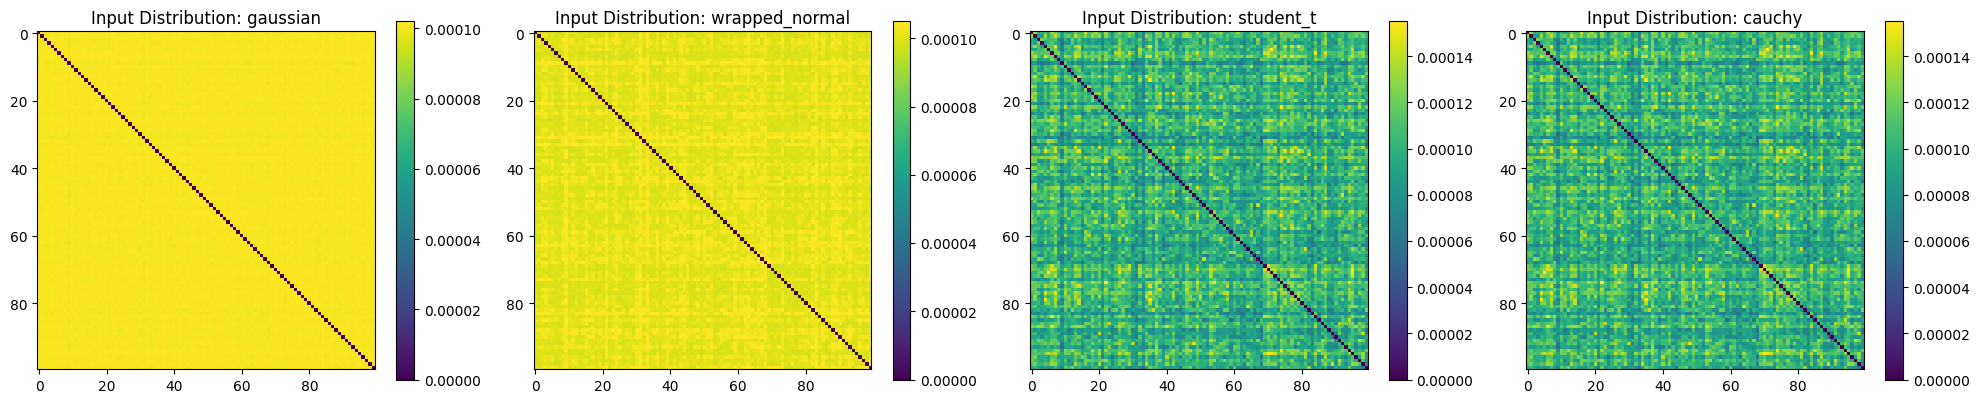


Comparing output space distributions...
Computing Student's t probabilities...
Computing Gaussian probabilities...
Computing Cauchy probabilities...
Computing von Mises-Fisher probabilities...


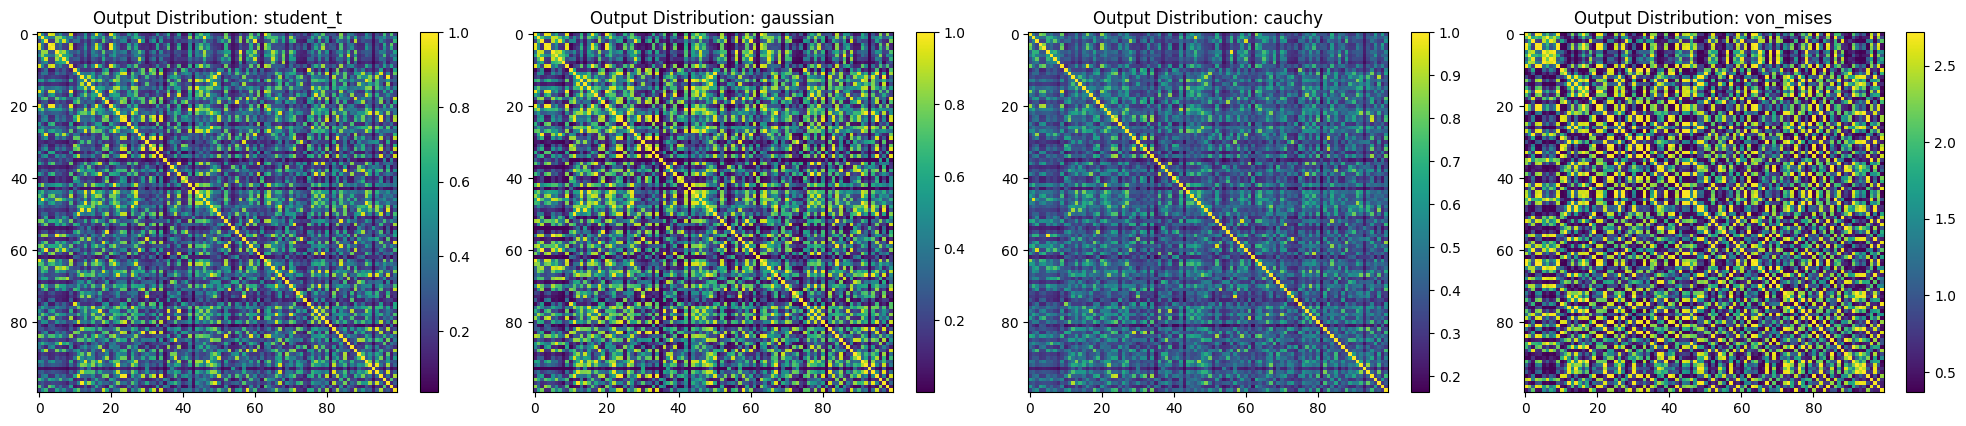


Distribution Statistics:

Input Space:
gaussian:
  Mean: 0.0001
  Std:  0.0000
  Max:  0.0001
  Min:  0.0000
wrapped_normal:
  Mean: 0.0001
  Std:  0.0000
  Max:  0.0001
  Min:  0.0000
student_t:
  Mean: 0.0001
  Std:  0.0000
  Max:  0.0002
  Min:  0.0000
cauchy:
  Mean: 0.0001
  Std:  0.0000
  Max:  0.0002
  Min:  0.0000

Output Space:
student_t:
  Mean: 0.3721
  Std:  0.2401
  Max:  1.0000
  Min:  0.0364
gaussian:
  Mean: 0.3801
  Std:  0.3027
  Max:  1.0000
  Min:  0.0000
cauchy:
  Mean: 0.4300
  Std:  0.1516
  Max:  1.0000
  Min:  0.1627
von_mises:
  Mean: 1.2798
  Std:  0.8340
  Max:  2.7183
  Min:  0.3679


In [39]:
# ===== Distribution Experiments =====
class DistributionExperiments:
    """Experiments with different input and output space distributions"""

    def __init__(self, device=None):
        self.device = device if device is not None else \
                     torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Initialized Distribution Experiments on device: {self.device}")

    def compare_input_distributions(self, X, perplexity=30.0):
        """
        Compare different input space distributions

        Parameters:
        -----------
        X : array-like
            Input data
        perplexity : float
            Perplexity parameter for probability computation

        Returns:
        --------
        dict
            Dictionary containing similarity matrices for each distribution
        """
        print("\nComparing input space distributions...")
        results = {}

        # Convert input to tensor if needed
        X = torch.tensor(X, device=self.device) if not isinstance(X, torch.Tensor) else X

        # Gaussian (original t-SNE)
        print("Computing Gaussian similarities...")
        gaussian_dist = lambda x: torch.exp(-x**2 / (2 * perplexity**2))
        results['gaussian'] = self._compute_similarities(X, gaussian_dist)

        # Wrapped Normal (for non-Euclidean spaces)
        print("Computing Wrapped Normal similarities...")
        wrapped_normal = lambda x: torch.exp(torch.cos(x) / perplexity)
        results['wrapped_normal'] = self._compute_similarities(X, wrapped_normal)

        # Student's t (heavy-tailed alternative)
        print("Computing Student's t similarities...")
        student_t = lambda x: torch.pow(1 + x**2/perplexity, -1)
        results['student_t'] = self._compute_similarities(X, student_t)

        # Cauchy (for hyperbolic space)
        print("Computing Cauchy similarities...")
        cauchy = lambda x: 1 / (1 + x**2/perplexity)
        results['cauchy'] = self._compute_similarities(X, cauchy)

        return results

    def compare_output_distributions(self, Y):
        """
        Compare different output space distributions

        Parameters:
        -----------
        Y : array-like
            Embedded points

        Returns:
        --------
        dict
            Dictionary containing probability distributions
        """
        print("\nComparing output space distributions...")
        results = {}

        # Convert input to tensor if needed
        Y = torch.tensor(Y, device=self.device) if not isinstance(Y, torch.Tensor) else Y

        # Compute pairwise distances
        distances = torch.cdist(Y, Y)

        # Student's t (original t-SNE)
        print("Computing Student's t probabilities...")
        results['student_t'] = 1 / (1 + distances**2)

        # Gaussian (original SNE)
        print("Computing Gaussian probabilities...")
        results['gaussian'] = torch.exp(-distances**2 / 2)

        # Cauchy (for hyperbolic space)
        print("Computing Cauchy probabilities...")
        results['cauchy'] = 1 / (1 + distances)

        # Spherical von Mises-Fisher
        print("Computing von Mises-Fisher probabilities...")
        Y_normalized = Y / torch.norm(Y, dim=1, keepdim=True)
        cosine_sim = torch.mm(Y_normalized, Y_normalized.t())
        results['von_mises'] = torch.exp(cosine_sim)

        return results

    def _compute_similarities(self, X, kernel_func):
        """Helper function to compute similarity matrices"""
        distances = torch.cdist(X, X)
        similarities = kernel_func(distances)

        # Zero out diagonal
        similarities.fill_diagonal_(0)

        # Normalize
        return similarities / torch.sum(similarities)

    def visualize_distribution_comparison(self, results, title_prefix=""):
        """Visualize distribution comparison results"""
        n_distributions = len(results)
        fig, axes = plt.subplots(1, n_distributions, figsize=(5*n_distributions, 4))

        for idx, (name, matrix) in enumerate(results.items()):
            if isinstance(matrix, torch.Tensor):
                matrix = matrix.cpu().numpy()

            im = axes[idx].imshow(matrix, cmap='viridis')
            axes[idx].set_title(f"{title_prefix} {name}")
            plt.colorbar(im, ax=axes[idx])

        plt.tight_layout()
        plt.show()

# Test the distribution experiments
if __name__ == "__main__":
    # Create synthetic data
    n_samples = 100
    n_features = 10
    X = np.random.randn(n_samples, n_features)
    Y = np.random.randn(n_samples, 2)  # 2D embedding

    # Initialize experiments
    dist_experiments = DistributionExperiments()

    # Compare input distributions
    input_results = dist_experiments.compare_input_distributions(X)
    dist_experiments.visualize_distribution_comparison(
        input_results, "Input Distribution:")

    # Compare output distributions
    output_results = dist_experiments.compare_output_distributions(
        torch.tensor(Y))
    dist_experiments.visualize_distribution_comparison(
        output_results, "Output Distribution:")

    # Print statistics
    print("\nDistribution Statistics:")
    for space in ['input', 'output']:
        results = input_results if space == 'input' else output_results
        print(f"\n{space.capitalize()} Space:")
        for dist_name, matrix in results.items():
            if isinstance(matrix, torch.Tensor):
                matrix = matrix.cpu().numpy()
            print(f"{dist_name}:")
            print(f"  Mean: {matrix.mean():.4f}")
            print(f"  Std:  {matrix.std():.4f}")
            print(f"  Max:  {matrix.max():.4f}")
            print(f"  Min:  {matrix.min():.4f}")

Initialized Divergence Measures

Divergence Measures Comparison:
KL                  : 0.898339
Reverse KL          : 0.820121
Jensen-Shannon      : 0.170309
Hellinger           : 0.433153
Squared Hellinger   : 0.187622
Pearson Chi-Squared : 6.512629
Total Variation     : 0.472498
Alpha (0.5)         : 0.750487
Alpha (2.0)         : 3.256314
f-divergence (KL)   : 0.898339
f-divergence (Chi)  : 6.512629


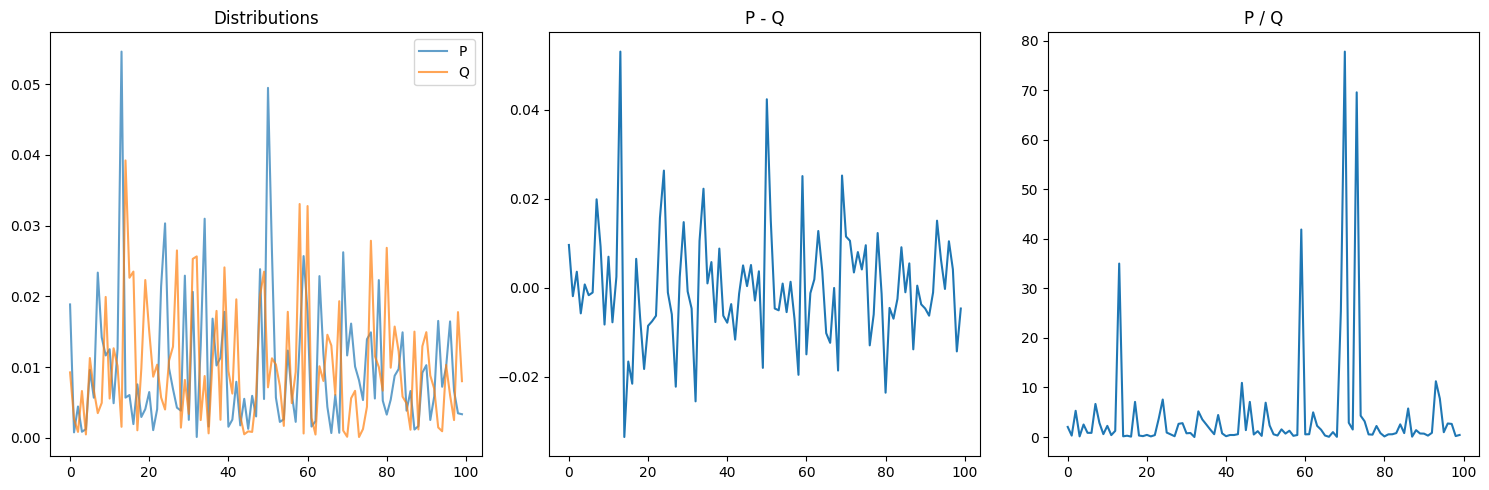

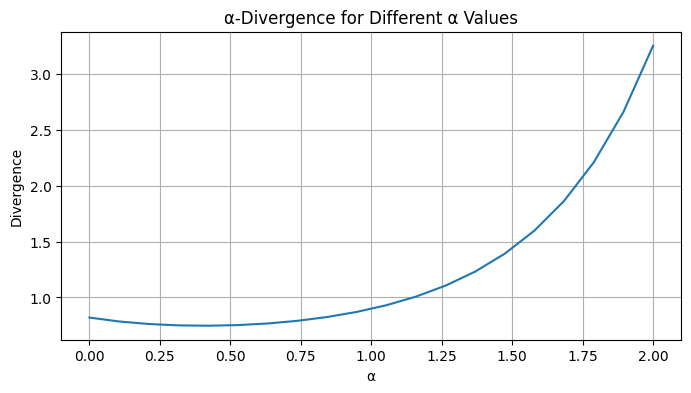

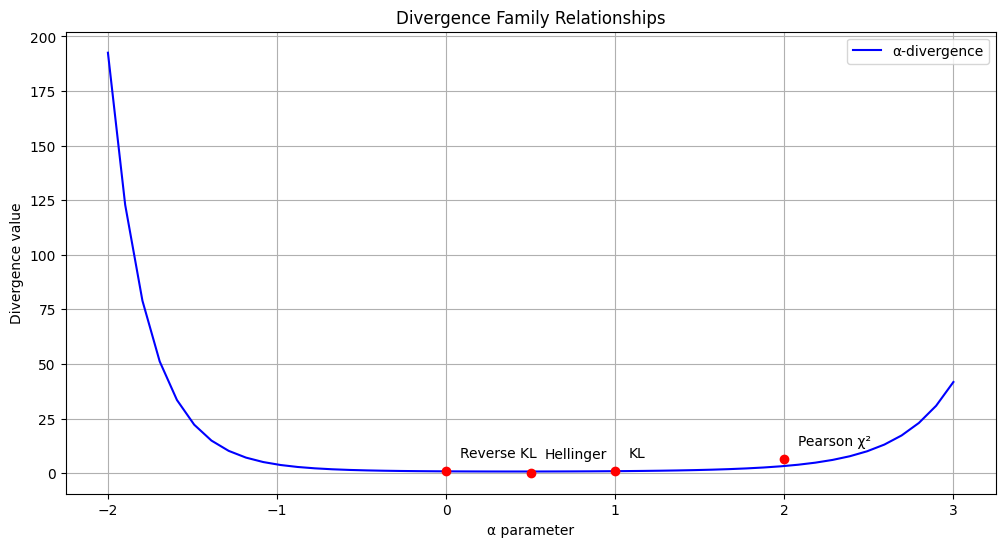

In [40]:
# ===== Divergence Experiments =====
class DivergenceMeasures:
    """Implementation of various divergence measures for distribution comparison"""

    def __init__(self, epsilon=1e-10):
        self.epsilon = epsilon
        print("Initialized Divergence Measures")

    def kl_divergence(self, P, Q):
        """
        Kullback-Leibler divergence (original t-SNE)

        Parameters:
        -----------
        P, Q : array-like
            Input probability distributions

        Returns:
        --------
        float
            KL divergence value
        """
        P = np.clip(P, self.epsilon, 1.0)
        Q = np.clip(Q, self.epsilon, 1.0)
        return np.sum(P * np.log(P / Q))

    def jensen_shannon(self, P, Q):
        """Jensen-Shannon divergence"""
        P = np.clip(P, self.epsilon, 1.0)
        Q = np.clip(Q, self.epsilon, 1.0)
        M = 0.5 * (P + Q)
        return 0.5 * (self.kl_divergence(P, M) + self.kl_divergence(Q, M))

    def hellinger_distance(self, P, Q):
        """Hellinger distance"""
        P = np.clip(P, self.epsilon, 1.0)
        Q = np.clip(Q, self.epsilon, 1.0)
        return np.sqrt(0.5 * np.sum((np.sqrt(P) - np.sqrt(Q))**2))

    def pearson_chi_squared(self, P, Q):
        """
        Pearson χ² divergence
        D_χ²(P||Q) = ∫ (p(x) - q(x))²/q(x) dx
        """
        P = np.clip(P, self.epsilon, 1.0)
        Q = np.clip(Q, self.epsilon, 1.0)
        return np.sum((P - Q)**2 / Q)

    def reverse_kl(self, P, Q):
        """
        Reverse KL divergence
        D_RKL(P||Q) = KL(Q||P)
        """
        return self.kl_divergence(Q, P)

    def total_variation(self, P, Q):
        """
        Total variation distance
        D_TV(P||Q) = (1/2) ∫ |p(x) - q(x)| dx
        """
        P = np.clip(P, self.epsilon, 1.0)
        Q = np.clip(Q, self.epsilon, 1.0)
        return 0.5 * np.sum(np.abs(P - Q))

    def squared_hellinger(self, P, Q):
        """
        Squared Hellinger distance
        H²(P,Q) = (1/2) ∫ (√p(x) - √q(x))² dx
        """
        P = np.clip(P, self.epsilon, 1.0)
        Q = np.clip(Q, self.epsilon, 1.0)
        return 0.5 * np.sum((np.sqrt(P) - np.sqrt(Q))**2)

    def alpha_divergence(self, P, Q, alpha=0.5):
        """
        α-divergence with parameter alpha

        Note:
        - α = 1 gives KL(P||Q)
        - α = 0 gives KL(Q||P)
        - α = 0.5 gives Hellinger distance
        """
        P = np.clip(P, self.epsilon, 1.0)
        Q = np.clip(Q, self.epsilon, 1.0)

        if np.abs(alpha - 1) < self.epsilon:
            return self.kl_divergence(P, Q)
        elif np.abs(alpha) < self.epsilon:
            return self.kl_divergence(Q, P)
        else:
            return (np.sum(P**alpha * Q**(1-alpha)) - 1) / (alpha * (alpha - 1))

    def f_divergence(self, P, Q, f, f_prime):
        """
        Generic f-divergence with custom function f and its derivative f_prime

        Parameters:
        -----------
        P, Q : array-like
            Input probability distributions
        f : callable
            f-divergence function
        f_prime : callable
            Derivative of f-divergence function
        """
        P = np.clip(P, self.epsilon, 1.0)
        Q = np.clip(Q, self.epsilon, 1.0)
        ratio = P / Q
        return np.sum(Q * f(ratio))

    def compare_divergences(self, P, Q):
        """Compare different divergence measures between P and Q"""
        results = {
            'KL': self.kl_divergence(P, Q),
            'Reverse KL': self.reverse_kl(P, Q),
            'Jensen-Shannon': self.jensen_shannon(P, Q),
            'Hellinger': self.hellinger_distance(P, Q),
            'Squared Hellinger': self.squared_hellinger(P, Q),
            'Pearson Chi-Squared': self.pearson_chi_squared(P, Q),
            'Total Variation': self.total_variation(P, Q),
            'Alpha (0.5)': self.alpha_divergence(P, Q, 0.5),
            'Alpha (2.0)': self.alpha_divergence(P, Q, 2.0)
        }

        # Example f-divergences
        # KL divergence as f-divergence
        f_kl = lambda x: x * np.log(x)
        f_kl_prime = lambda x: np.log(x) + 1
        results['f-divergence (KL)'] = self.f_divergence(P, Q, f_kl, f_kl_prime)

        # Pearson χ² as f-divergence
        f_chi = lambda x: (x - 1)**2
        f_chi_prime = lambda x: 2*(x - 1)
        results['f-divergence (Chi)'] = self.f_divergence(P, Q, f_chi, f_chi_prime)

        return results

    def visualize_divergence_family(self, P, Q, alphas=np.linspace(-2, 3, 50)):
        """Visualize how different divergence measures relate to alpha-divergence"""
        plt.figure(figsize=(12, 6))

        # Compute alpha-divergence values
        alpha_values = [self.alpha_divergence(P, Q, alpha) for alpha in alphas]

        # Plot alpha-divergence curve
        plt.plot(alphas, alpha_values, 'b-', label='α-divergence')

        # Add special points
        special_points = {
            'KL': (1, self.kl_divergence(P, Q)),
            'Reverse KL': (0, self.reverse_kl(P, Q)),
            'Hellinger': (0.5, self.hellinger_distance(P, Q)**2),
            'Pearson χ²': (2, self.pearson_chi_squared(P, Q)),
        }

        # Plot special points
        for name, (x, y) in special_points.items():
            plt.plot(x, y, 'ro')
            plt.annotate(name, (x, y), xytext=(10, 10),
                        textcoords='offset points')

        plt.title('Divergence Family Relationships')
        plt.xlabel('α parameter')
        plt.ylabel('Divergence value')
        plt.grid(True)
        plt.legend()
        plt.show()

# Test the divergence measures
if __name__ == "__main__":
    # Create sample probability distributions
    n_samples = 100

    # Create slightly different distributions for testing
    P = np.random.dirichlet(alpha=[1.0]*n_samples)
    Q = np.random.dirichlet(alpha=[1.2]*n_samples)  # Slightly different concentration

    # Normalize to ensure they sum to 1
    P = P / P.sum()
    Q = Q / Q.sum()

    # Initialize and test divergence measures
    div_measures = DivergenceMeasures()
    results = div_measures.compare_divergences(P, Q)

    # Print results
    print("\nDivergence Measures Comparison:")
    for name, value in results.items():
        print(f"{name:20s}: {value:.6f}")

    # Visualize distributions and their differences
    plt.figure(figsize=(15, 5))

    # Plot distributions
    plt.subplot(131)
    plt.plot(P, label='P', alpha=0.7)
    plt.plot(Q, label='Q', alpha=0.7)
    plt.title('Distributions')
    plt.legend()

    # Plot difference
    plt.subplot(132)
    plt.plot(P - Q)
    plt.title('P - Q')

    # Plot ratio
    plt.subplot(133)
    plt.plot(P / Q)
    plt.title('P / Q')

    plt.tight_layout()
    plt.show()

    # Effect of alpha parameter
    alphas = np.linspace(0, 2, 20)
    alpha_values = [div_measures.alpha_divergence(P, Q, alpha) for alpha in alphas]

    plt.figure(figsize=(8, 4))
    plt.plot(alphas, alpha_values)
    plt.title('α-Divergence for Different α Values')
    plt.xlabel('α')
    plt.ylabel('Divergence')
    plt.grid(True)
    plt.show()

    # Visualize relationships between divergences
    div_measures.visualize_divergence_family(P, Q)

Initialized Distribution Experiments on device: cpu
Initialized Divergence Measures
Initialized Comparative Analysis

Comparing input distributions...

Comparing input space distributions...
Computing Gaussian similarities...
Computing Wrapped Normal similarities...
Computing Student's t similarities...
Computing Cauchy similarities...

Generating baseline t-SNE embedding...

Generating Mixed-Curvature t-SNE embedding...
Initialized MixedCurvatureTSNE with parameters:  {'product_space': <__main__.ProductSpace object at 0x0000023081243160>, 'perplexity': 30, 'n_components': 2, 'learning_rate': 200, 'max_iter': 1000, 'random_state': 42, 'best_cost_': inf}
Initialized on device: cpu
Transition parameters: {'boundary_width': 0.1, 'smoothing_factor': 0.2, 'repulsion_strength': 0.4, 'radial_force': 0.18, 'cluster_force': 0.25, 'boundary_repulsion': 0.15}

Starting enhanced fit_transform with 1000 samples...
Input data shape: (1000, 784)
Product space signature: [(2, -1.0), (2, 0.0)]

Process

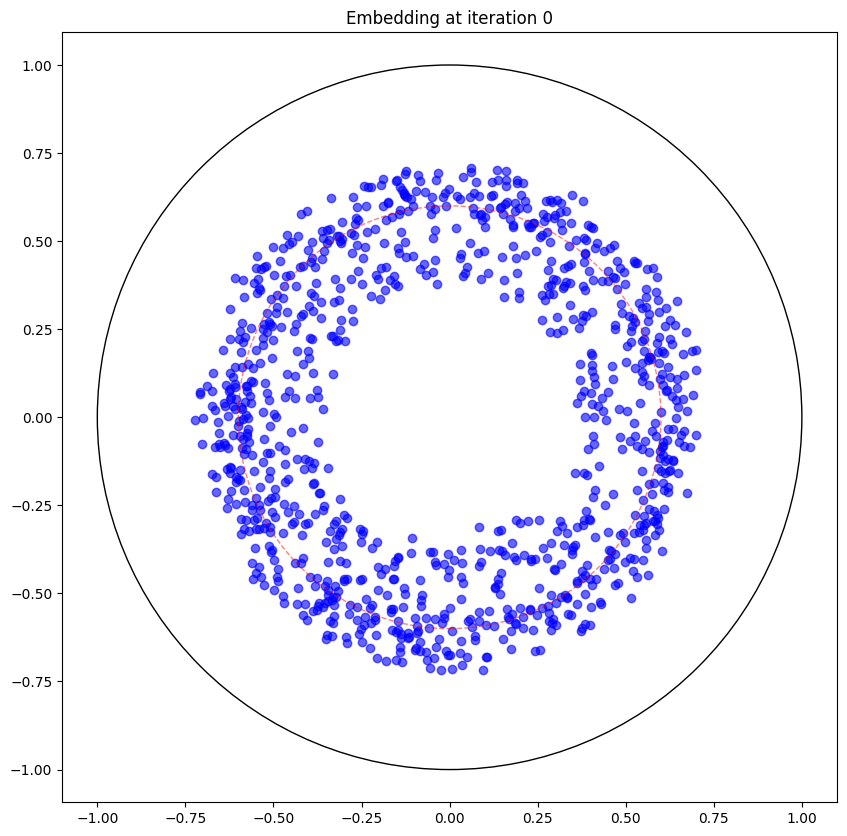

Iteration 50: Cost = -0.0000, Max norm = 0.6875, Mean norm = 0.6092, Learning rate = 160.0000
Iteration 100: Cost = -0.0000, Max norm = 0.6869, Mean norm = 0.6097, Learning rate = 160.0000
Iteration 150: Cost = -0.0000, Max norm = 0.6860, Mean norm = 0.6079, Learning rate = 160.0000
Iteration 200: Cost = -0.0000, Max norm = 0.6864, Mean norm = 0.6076, Learning rate = 160.0000


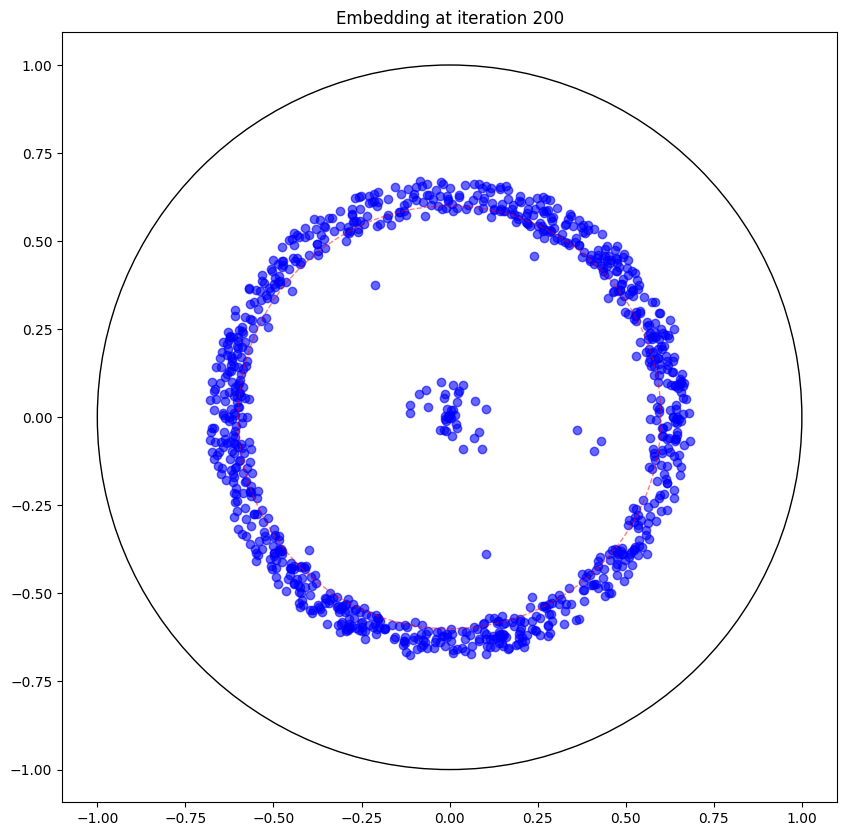

Iteration 250: Cost = -0.0000, Max norm = 0.7475, Mean norm = 0.5551, Learning rate = 160.0000
Iteration 300: Cost = -0.0000, Max norm = 0.7466, Mean norm = 0.5443, Learning rate = 152.1929
Iteration 350: Cost = -0.0000, Max norm = 0.7387, Mean norm = 0.5483, Learning rate = 144.7667
Iteration 400: Cost = -0.0000, Max norm = 0.7476, Mean norm = 0.5640, Learning rate = 137.7029


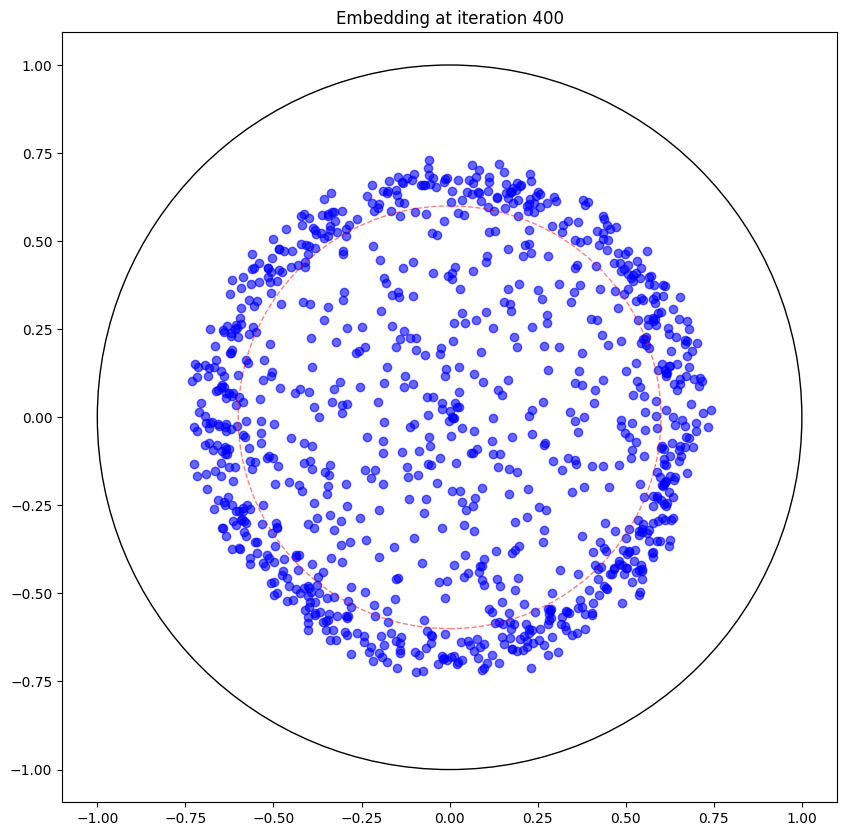

Iteration 450: Cost = -0.0000, Max norm = 0.7368, Mean norm = 0.5658, Learning rate = 130.9838
Iteration 500: Cost = -0.0000, Max norm = 0.7449, Mean norm = 0.5606, Learning rate = 124.5925
Iteration 550: Cost = -0.0000, Max norm = 0.7433, Mean norm = 0.5732, Learning rate = 118.5131
Early stopping due to no improvement

Comparing output distributions...

Comparing output space distributions...
Computing Student's t probabilities...
Computing Gaussian probabilities...
Computing Cauchy probabilities...
Computing von Mises-Fisher probabilities...

Comparing output space distributions...
Computing Student's t probabilities...
Computing Gaussian probabilities...
Computing Cauchy probabilities...
Computing von Mises-Fisher probabilities...

Computing divergences...


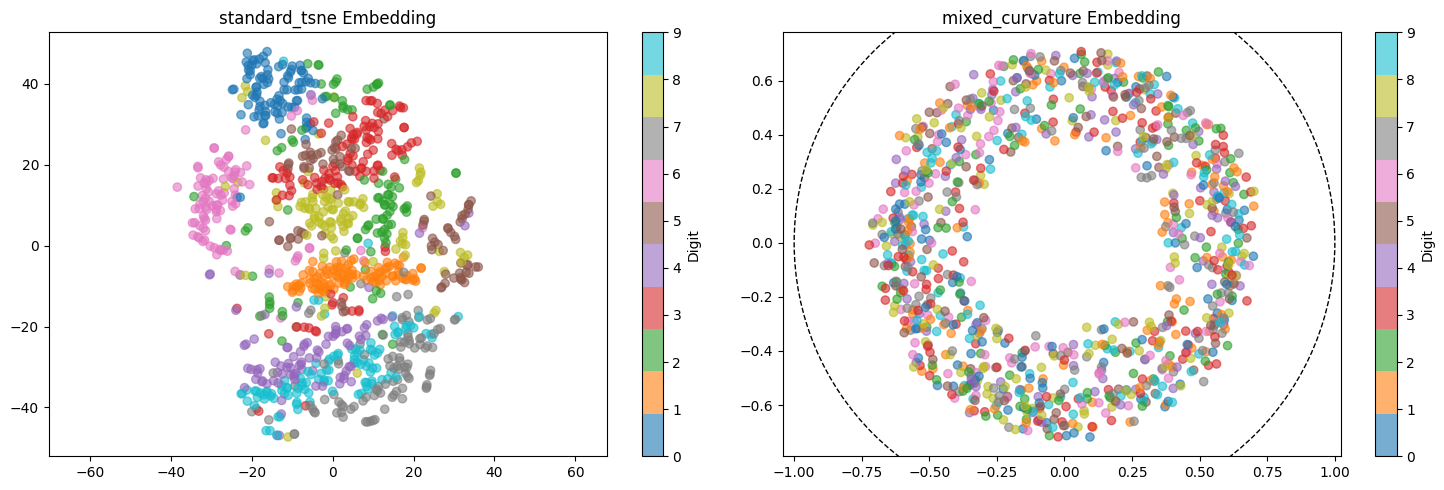

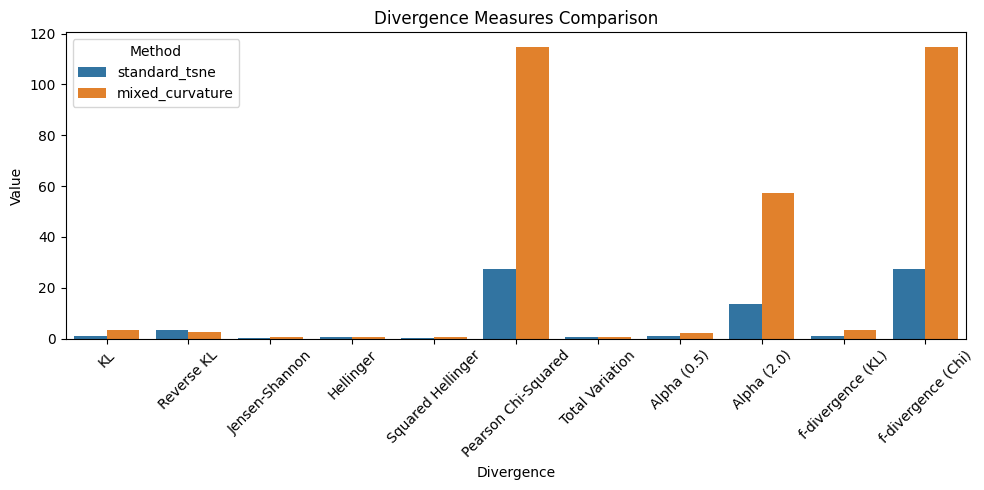


Detailed Statistics:

standard_tsne:
  KL             : 1.082896
  Reverse KL     : 3.228331
  Jensen-Shannon : 0.221357
  Hellinger      : 0.518623
  Squared Hellinger: 0.268970
  Pearson Chi-Squared: 27.280065
  Total Variation: 0.518523
  Alpha (0.5)    : 1.075879
  Alpha (2.0)    : 13.640033
  f-divergence (KL): 1.082896
  f-divergence (Chi): 27.280065

mixed_curvature:
  KL             : 3.261409
  Reverse KL     : 2.640169
  Jensen-Shannon : 0.441674
  Hellinger      : 0.732061
  Squared Hellinger: 0.535914
  Pearson Chi-Squared: 114.770902
  Total Variation: 0.797233
  Alpha (0.5)    : 2.143654
  Alpha (2.0)    : 57.385452
  f-divergence (KL): 3.261409
  f-divergence (Chi): 114.770902


In [42]:
# ===== Comparative Analysis =====
import pandas as pd
import seaborn as sns

class ComparativeAnalysis:
    """Compare different combinations of distributions and divergences"""

    def __init__(self, product_space, random_state=42):
        self.product_space = product_space
        self.dist_experiments = DistributionExperiments()
        self.div_measures = DivergenceMeasures()
        self.random_state = random_state
        print("Initialized Comparative Analysis")

    def _compute_joint_probabilities(self, distances, perplexity, verbose=False):
        """Compute joint probabilities using binary search for sigma"""
        n_samples = distances.shape[0]
        P = np.zeros((n_samples, n_samples))
        beta = np.ones(n_samples)
        logU = np.log(perplexity)

        for i in range(n_samples):
            if verbose and i % 500 == 0:
                print(f"Computing probabilities for point {i}/{n_samples}")

            betamin = -np.inf
            betamax = np.inf
            Di = distances[i, np.concatenate((np.r_[0:i], np.r_[i+1:n_samples]))]

            # Binary search for sigma_i
            for _ in range(50):
                H = 0
                Pj = np.exp(-Di * beta[i])
                sumPj = np.sum(Pj)
                if sumPj == 0:
                    H = 0
                else:
                    H = np.log(sumPj) + beta[i] * np.sum(Di * Pj) / sumPj
                Hdiff = H - logU

                if np.abs(Hdiff) < 1e-5:
                    break

                if Hdiff > 0:
                    betamin = beta[i]
                    if betamax == np.inf:
                        beta[i] = beta[i] * 2
                    else:
                        beta[i] = (beta[i] + betamax) / 2
                else:
                    betamax = beta[i]
                    if betamin == -np.inf:
                        beta[i] = beta[i] / 2
                    else:
                        beta[i] = (beta[i] + betamin) / 2

            # Set probabilities
            Pj = np.exp(-Di * beta[i])
            P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n_samples]))] = Pj / np.sum(Pj)

        return (P + P.T) / (2 * n_samples)

    def run_full_comparison(self, X, y=None, n_components=2, perplexity=30):
        """Run comprehensive comparison of different configurations"""
        results = {}

        # Ensure y is integer type if provided
        if y is not None:
            y = y.astype(int)

        # Compare different input distributions
        print("\nComparing input distributions...")
        input_distributions = self.dist_experiments.compare_input_distributions(X, perplexity)

        # Generate embeddings with different configurations
        embeddings = {}
        labels = {}

        # Standard t-SNE (baseline)
        print("\nGenerating baseline t-SNE embedding...")
        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=self.random_state)
        embeddings['standard_tsne'] = tsne.fit_transform(X)
        labels['standard_tsne'] = y if y is not None else np.zeros(len(X))

        # Enhanced Mixed-Curvature t-SNE
        print("\nGenerating Mixed-Curvature t-SNE embedding...")
        enhanced_tsne = EnhancedMixedCurvatureTSNE(
            product_space=self.product_space,
            perplexity=perplexity,
            n_components=n_components,
            random_state=self.random_state
        )
        embeddings['mixed_curvature'] = enhanced_tsne.fit_transform(X)
        labels['mixed_curvature'] = y if y is not None else np.zeros(len(X))

        # Compare output distributions
        print("\nComparing output distributions...")
        output_results = {}
        for name, embedding in embeddings.items():
            output_results[name] = self.dist_experiments.compare_output_distributions(
                torch.tensor(embedding))

        # Compare divergences
        print("\nComputing divergences...")
        divergence_results = {}
        for name, embedding in embeddings.items():
            # Compute high-dimensional probabilities
            distances_hd = pairwise_distances(X)
            P = self._compute_joint_probabilities(distances_hd, perplexity)

            # Compute low-dimensional probabilities
            distances_ld = pairwise_distances(embedding)
            Q = 1 / (1 + distances_ld ** 2)
            Q = Q / np.sum(Q)

            # Compute various divergences
            divergence_results[name] = self.div_measures.compare_divergences(P, Q)

        # Store all results
        results['input_distributions'] = input_distributions
        results['embeddings'] = embeddings
        results['labels'] = labels
        results['output_distributions'] = output_results
        results['divergences'] = divergence_results

        return results

    def visualize_results(self, results):
        """Visualize comparative analysis results"""
        # Plot embeddings
        plt.figure(figsize=(15, 5))
        for idx, (name, embedding) in enumerate(results['embeddings'].items()):
            plt.subplot(1, len(results['embeddings']), idx+1)
            scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                       c=results['labels'][name].astype(int),
                       cmap='tab10', alpha=0.6)
            plt.colorbar(scatter, label='Digit')
            plt.title(f'{name} Embedding')
            if name == 'mixed_curvature':
                circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
                plt.gca().add_artist(circle)
            plt.axis('equal')
        plt.tight_layout()
        plt.show()

        # Plot divergence comparisons
        plt.figure(figsize=(10, 5))
        div_data = []
        methods = []
        div_types = []
        for method, divs in results['divergences'].items():
            for div_type, value in divs.items():
                div_data.append(value)
                methods.append(method)
                div_types.append(div_type)

        df = pd.DataFrame({
            'Method': methods,
            'Divergence': div_types,
            'Value': div_data
        })

        sns.barplot(data=df, x='Divergence', y='Value', hue='Method')
        plt.xticks(rotation=45)
        plt.title('Divergence Measures Comparison')
        plt.tight_layout()
        plt.show()

        # Print detailed statistics
        print("\nDetailed Statistics:")
        for method, divs in results['divergences'].items():
            print(f"\n{method}:")
            for div_type, value in divs.items():
                print(f"  {div_type:15s}: {value:.6f}")

# Test the comparative analysis
if __name__ == "__main__":
    # Use MNIST subset for testing
    X_mnist, y_mnist = load_mnist(n_samples=1000)

    # Create product space
    signature = [(2, -1.0), (2, 0.0)]  # Hyperbolic and Euclidean
    product_space = ProductSpace(signature=signature, seed=42)

    # Initialize and run comparative analysis
    analyzer = ComparativeAnalysis(product_space)
    results = analyzer.run_full_comparison(X_mnist, y_mnist)

    # Visualize results
    analyzer.visualize_results(results)


Initializing CO-SNE...

Fitting CO-SNE to data...
Iteration 0: Max norm = 1.0000, Mean norm = 0.3315, Learning rate = 10.000000, Momentum = 0.8000
Iteration 50: Max norm = 1.0000, Mean norm = 0.6102, Learning rate = 10.000000, Momentum = 0.8000
Iteration 100: Max norm = 1.0000, Mean norm = 0.5682, Learning rate = 10.000000, Momentum = 0.8000
Iteration 150: Max norm = 1.0000, Mean norm = 0.5717, Learning rate = 10.000000, Momentum = 0.8000
Iteration 200: Max norm = 1.0000, Mean norm = 0.5576, Learning rate = 10.000000, Momentum = 0.8000
Iteration 250: Max norm = 1.0000, Mean norm = 0.6609, Learning rate = 10.000000, Momentum = 0.8000
Iteration 300: Max norm = 1.0000, Mean norm = 0.5460, Learning rate = 9.753038, Momentum = 0.8100
Iteration 350: Max norm = 1.0000, Mean norm = 0.5664, Learning rate = 9.512175, Momentum = 0.8200
Iteration 400: Max norm = 1.0000, Mean norm = 0.5874, Learning rate = 9.277261, Momentum = 0.8300
Iteration 450: Max norm = 1.0000, Mean norm = 0.6192, Learning r

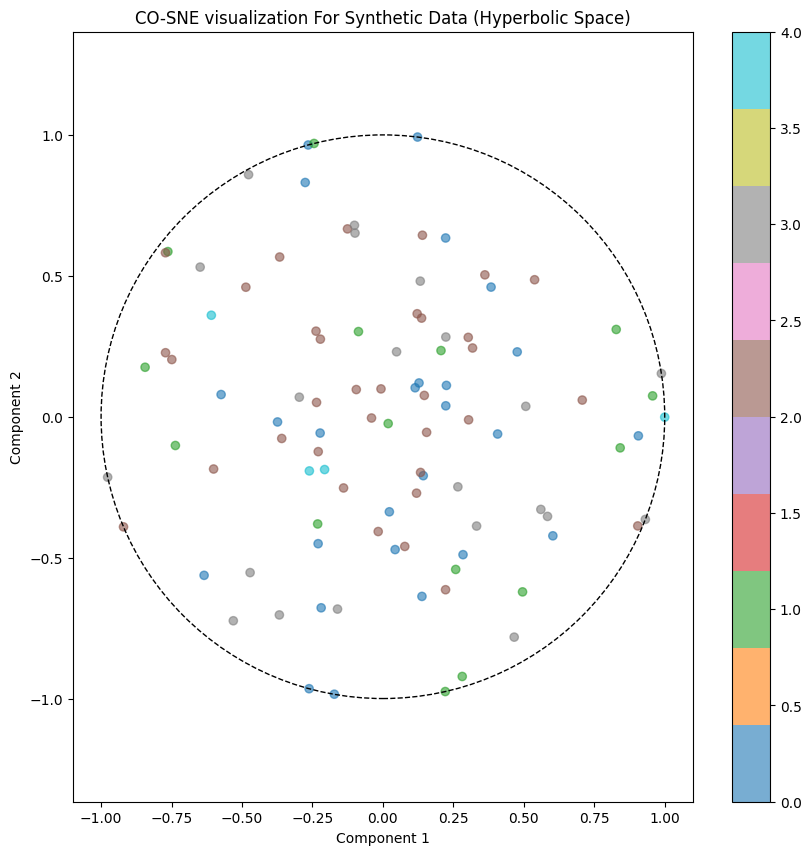


Embedding Statistics:
CO-SNE embedding shape: (100, 2)
Points outside unit disk: 0
Maximum distance from origin: 0.9999900000000003
Mean distance from origin: 0.5875621542629874


In [43]:
# test CO-SNE on synthetic data
# this replicates the results in the COSNE paper

# TODO: this result is bad, see text group for details

# Test implementation
if __name__ == "__main__":
    """
    Example usage and validation:
    1. Generate synthetic data
    2. Apply CO-SNE embedding
    3. Visualize results in Poincaré disk
    4. Report embedding statistics
    """

    # Load and preprocess data
    space_cosne_test = ProductSpace(signature=[(5, -1)], seed=42)
    centers_cosne_test = np.array([[0.1, 0, 0, 0, 0], [0, -0.2, 0, 0, 0], [0, 0, 0.9, 0, 0], [0, 0, 0, -0.9, 0], [0, 0, 0, 0, 0]])
    space_cosne_test.sample_clusters(num_points=100, num_classes=5, centers=centers_cosne_test, cov_scale=1)

    means_cosne = space_cosne_test.means
    X = space_cosne_test.X
    y = space_cosne_test.y

    # Initialize CO-SNE with optimized parameters
    print("\nInitializing CO-SNE...")
    """
    cosne = COSNE(
        random_state=42,
        learning_rate=50.0,
        max_iter=1000,
        perplexity=30.0,
        early_exaggeration=12.0,
        student_t_gamma=1.0,
        repulsion_strength=1.5,
        boundary_strength=0.15,
        radial_strength=0.4,
        momentum=0.8,
        late_momentum=0.9,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )
    """
    cosne = COSNE(
        random_state=42,
        learning_rate=10.0,
        max_iter=1000,
        perplexity=5.0,
        early_exaggeration=1.0,
        student_t_gamma=1.0,
        repulsion_strength=10.0,
        boundary_strength=0.01,
        radial_strength=0.4,
        momentum=0.8,
        late_momentum=0.9,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )

    # Fit and transform the data
    print("\nFitting CO-SNE to data...")
    X_embedded = cosne.fit_transform(X)

    # Visualization setup
    print("\nCreating visualization...")
    plt.figure(figsize=(10, 10))

    # Plot embedded points
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                         c=y, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)

    # Add unit circle to represent Poincaré disk boundary
    circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
    plt.gca().add_artist(circle)

    # Customize plot
    plt.title('CO-SNE visualization For Synthetic Data (Hyperbolic Space)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.show()

    # Print embedding statistics
    print("\nEmbedding Statistics:")
    print("CO-SNE embedding shape:", X_embedded.shape)
    print("Points outside unit disk:", np.sum(np.linalg.norm(X_embedded, axis=1) > 1))
    print("Maximum distance from origin:", np.max(np.linalg.norm(X_embedded, axis=1)))
    print("Mean distance from origin:", np.mean(np.linalg.norm(X_embedded, axis=1)))

In [ ]:
# TODO: implement Gu paper's visualization


